Evaluation
---
This notebook shows you how to evaluate a trained neural network, and also reproduces all the plots from the publication.

> **Note** Evaluating the neural network and loading the full table of estimates (`T.nc` in the `Estimates` folder) requires a decent amount of memory (`T.nc` alone is 3.5GB).
> We recommend evaluating the neural network on the GPU for faster performance, which requires a CUDA- (or MPS-) enabled installation of PyTorch.
> If you do not have this, set the default `torch` device to `cpu` (see below).

The first section shows you how to evaluate a trained network. Skip to the second half of the notebook if you only want to recreate the publication plots or use the estimates to create your own visualisations.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import xarray as xr
from ruamel.yaml import YAML

from Data import world, coordinates
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D

from dantro.plot.utils import ColorManager

yaml = YAML(typ='safe')

from matplotlib import rcParams
from Code.plot_style import colors, style
from Code import plot_utils as putils
from Code import utils as utils
rcParams.update(**style)

# Uniform page width for Latex integration
page_width = 6.62454 # inches

# Image directory
img_dir = "Images"

In [2]:
# Import the comparison flow datasets and UN WPP data
from Data import population, death_rate, WPP_net_migration, NatStat_net_migration, flow_dsets, countries_by_region, stock_data

# UNHCR refugee data
refugees = xr.open_dataarray("Data/UNHCR_data/refugee_data.nc").sel({'variable': ["Refugees under UNHCR's mandate", "Asylum-seekers", "Other people in need of international protection"]}).sum('variable')

# Load the true flows to compare
flow_data = xr.open_dataarray("Data/Flow_data/flows.nc")

# Example: generate estimates using the neural network


We recommend using a GPU to generate predictions with the neural network. If available, set the default device to 'cuda' or 'mps' (on Apple Silicon — note that this requires installation of a cuda- or AppleSilicon-compatible version of PyTorch. See the README).

In [3]:
# Device
device = 'mps'
torch.set_default_device(device)

First, we load all the training data into a single dictionary. The training data is located in the `Data/Training_data` folder. The function below will output a warning that now ground truth values were found – this can be ignored, since we are not comparing our results to any ground truths.

In [4]:
# Load all the data to a dictionary
with open(f"Code/cfg.yaml", "r") as file:
    cfg = yaml.load(file)
data = utils.load_training_data("Data/Training_data", cfg, device=device)
data['F_mask'] = data['F_mask'].to('cpu')

INFO: No ground truth values true_flow_table found.
INFO: No ground truth values true_stock found.
INFO: No ground truth values true_flow found.
INFO: No ground truth values true_net_migration found.


Now, generate the predictions using the neural network. We also calculate the five-year flows, and load the mask of test flows.

In [30]:
predictions = utils.get_predictions("Trained_networks/z_100_yj_05_eta_10", device='mps', show_pbar=True, **data)
predictions.update(utils.convert_tensor_predictions_to_xarray(
    **predictions, years=np.arange(1990, 2024, 1), countries=flow_data.coords['Origin ISO'].data)
)

# Calculate five-year flows
predictions['Five_year_flows'] = utils.aggregate_T(
    predictions['T_pred'], np.arange(1990, 2021, 5)
)

100%|██████████| 34/34 [00:07<00:00,  4.52it/s]


Let's compare some our estimated total origin-destination flows to the various datasets we are using to train the model.

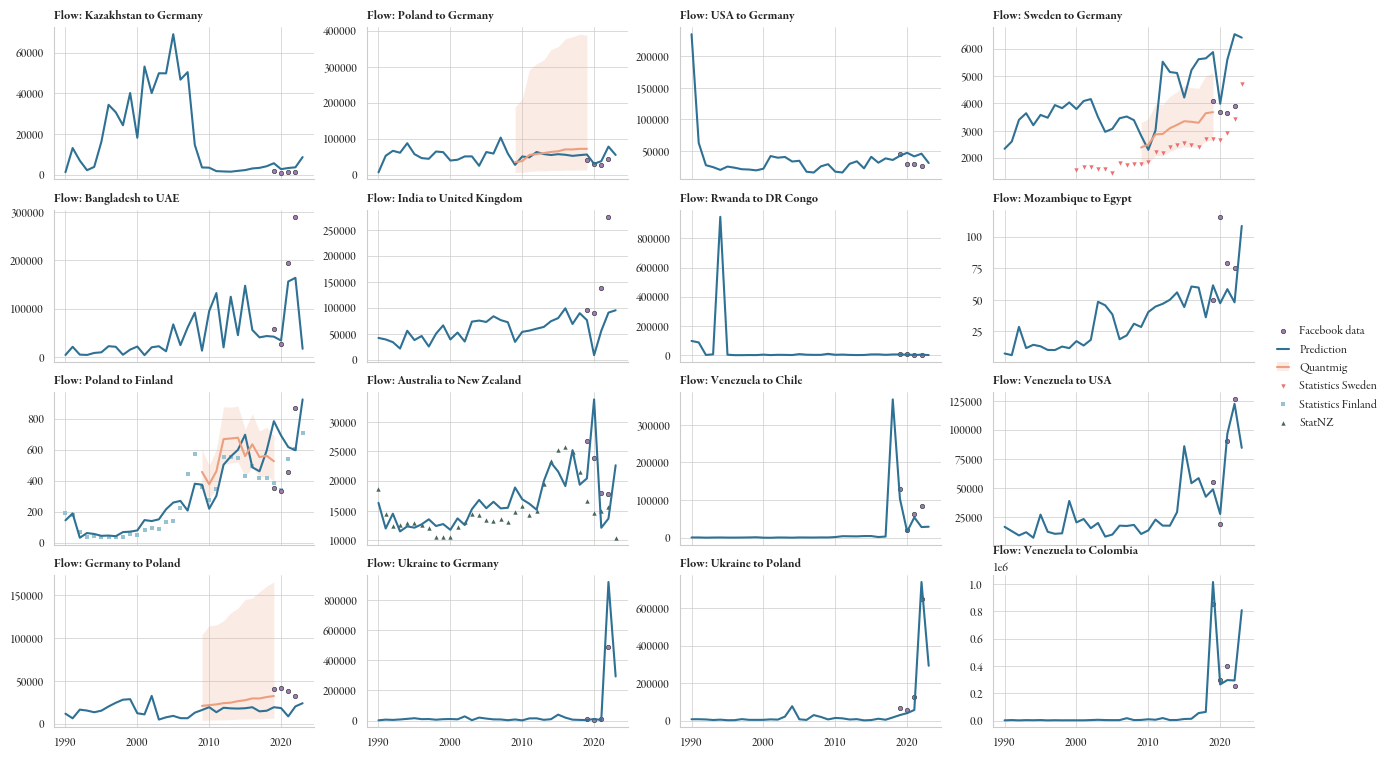

In [7]:
# Compare some flows
fig, axs = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(12, 7))

# Track handles and labels for the figure legend
handles = {}
for idx, (o, d) in enumerate([("KAZ", "DEU"), ("POL", "DEU"), ("USA", "DEU"), ("SWE", "DEU"), ("BGD", "ARE"), ("IND", "GBR"), ("RWA", "COD"), ("MOZ", "EGY"), ("POL", "FIN"), ("AUS", "NZL"), ("VEN", "CHL"), ("VEN", "USA"), ("DEU", "POL"), ("UKR", "DEU"), ("UKR", "POL"), ("VEN", "COL")]):
    l = predictions['F_pred'].sel({"Origin ISO": o, "Destination ISO": d}, drop=True).plot(ax=axs.flatten()[idx])

    handles.update(putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d))
    handles['Prediction'] = l[0]

# Add a legend
fig.legend(list(handles.values()), list(handles.keys()), bbox_to_anchor=(1.01, 0.5), loc='center left')

Let's plot some example stocks. The raw estimates are all conditioned on the first datapoint in the time series, that is the DESA estimate for 1990. However, this value might be erroneous. In order to improve the stock estimates, we can add a constant offset to each to better fit the time series. If we correct of demographic accounting (i.e. the death of the constant offset), this leaves the flow estimates unaffected. We calculate the offset by weighting the error between the prediction and DESA estimate with the weights from training, which reflect the error on the

In [8]:
# Calculate the fraction of population alive at start of 1990 in each destination country still alive at start of year
gamma = (1-death_rate.sel({"Year": range(1989, 2024)})).assign_coords({"Year": np.arange(1990, 2025, 1)}).rename({"Country ISO": "Destination ISO"})
gamma.loc[{"Year": 1990}] = 1.0
gamma = gamma.cumprod('Year')

# Calculate the stock offsets
stock_offset = utils.get_stock_offsets(
    stock_predictions=predictions['S_pred'].sel({"Year": stock_data.coords['Year']}),
    stock_data=stock_data['Start of year estimate'],
    weights=stock_data['Weight'].fillna(0),
    gamma=gamma
)

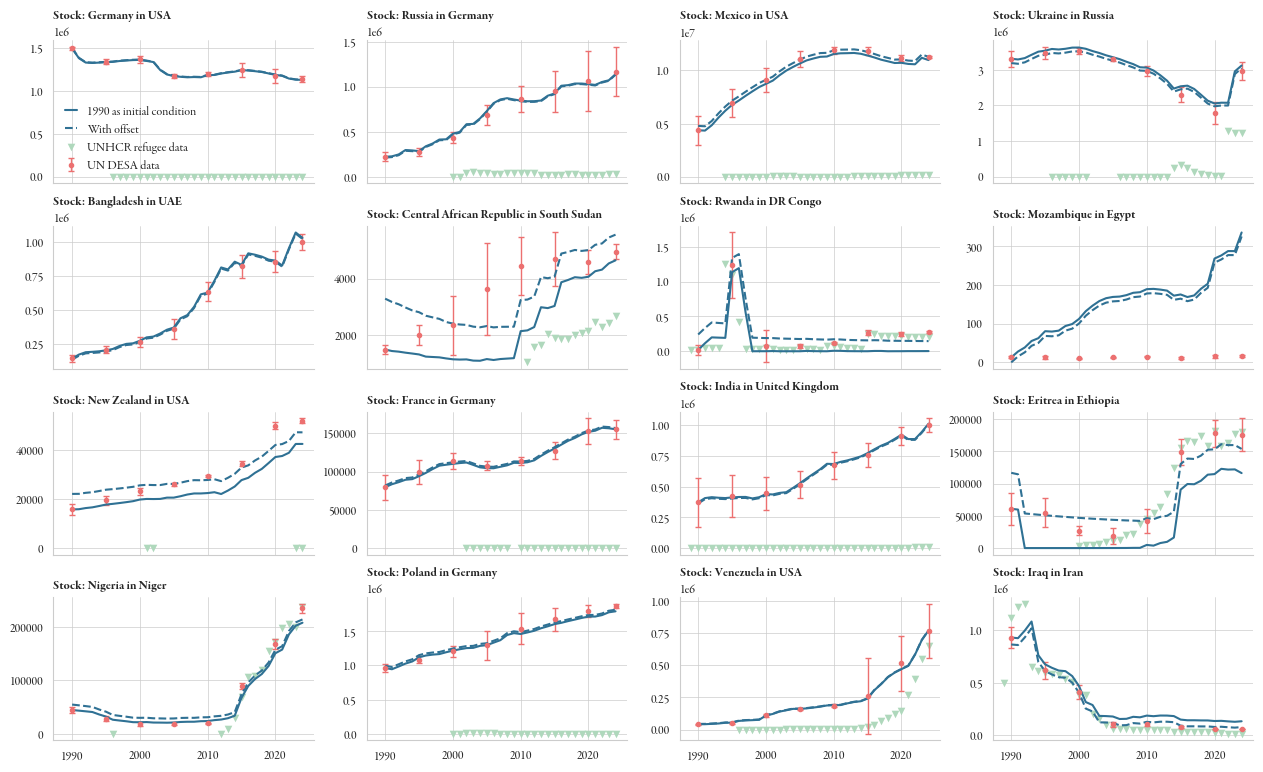

In [9]:
# Compare some stocks and compare with refugee data.
fig, axs = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(12, 7), gridspec_kw={'hspace': 0.3})

for idx, (o, d) in enumerate([("DEU", "USA"), ("RUS", "DEU"), ("MEX", "USA"), ("UKR", "RUS"), ("BGD", "ARE"), ("CAF", "SSD"), ("RWA", "COD"), ("MOZ", "EGY"), ("NZL", "USA"), ("FRA", "DEU"), ("IND", "GBR"), ("ERI", "ETH"), ("NGA", "NER"), ("POL", "DEU"), ("VEN", "USA"), ("IRQ", "IRN")]):

    # Plot the UN DESA stocks (scaled to the start of the year) as well as the error
    stock = stock_data.sel({"Origin ISO": o, "Destination ISO": d})
    axs.flatten()[idx].errorbar(
        stock.coords['Year'], stock['Start of year estimate'], stock['Error'], lw=0, color='C1', elinewidth=1, markersize=3, capsize=2, marker='o', label='UN DESA data' if idx == 0 else None
    )

    # Plot the neural estimates
    predictions['S_pred'].sel({"Origin ISO": o, "Destination ISO": d}).plot(
        ax=axs.flatten()[idx], label='1990 as initial condition')

    # Plot the neural estimates with the offset
    (predictions['S_pred'] + stock_offset).sel({"Origin ISO": o, "Destination ISO": d}).plot(
        ax=axs.flatten()[idx], ls='dashed', c='C0', label='With offset')

    # Plot the stock of refugees
    refugees.sel({"Origin ISO": o, "Destination ISO": d}, drop=True).where(lambda x: x>0).plot.scatter(
        ax=axs.flatten()[idx], label='UNHCR refugee data', s=30, lw=0, c=colors['c_lightgreen'], marker='v')

    # Descriptive title
    axs.flatten()[idx].set_title(f"Stock: {putils.iso_to_name(o)} in {putils.iso_to_name(d)}", x=0, ha='left', weight='bold')
    axs.flatten()[idx].set(xlabel=None, ylabel=None)
axs[0, 0].legend()

Let's also look at the net migration predictions.

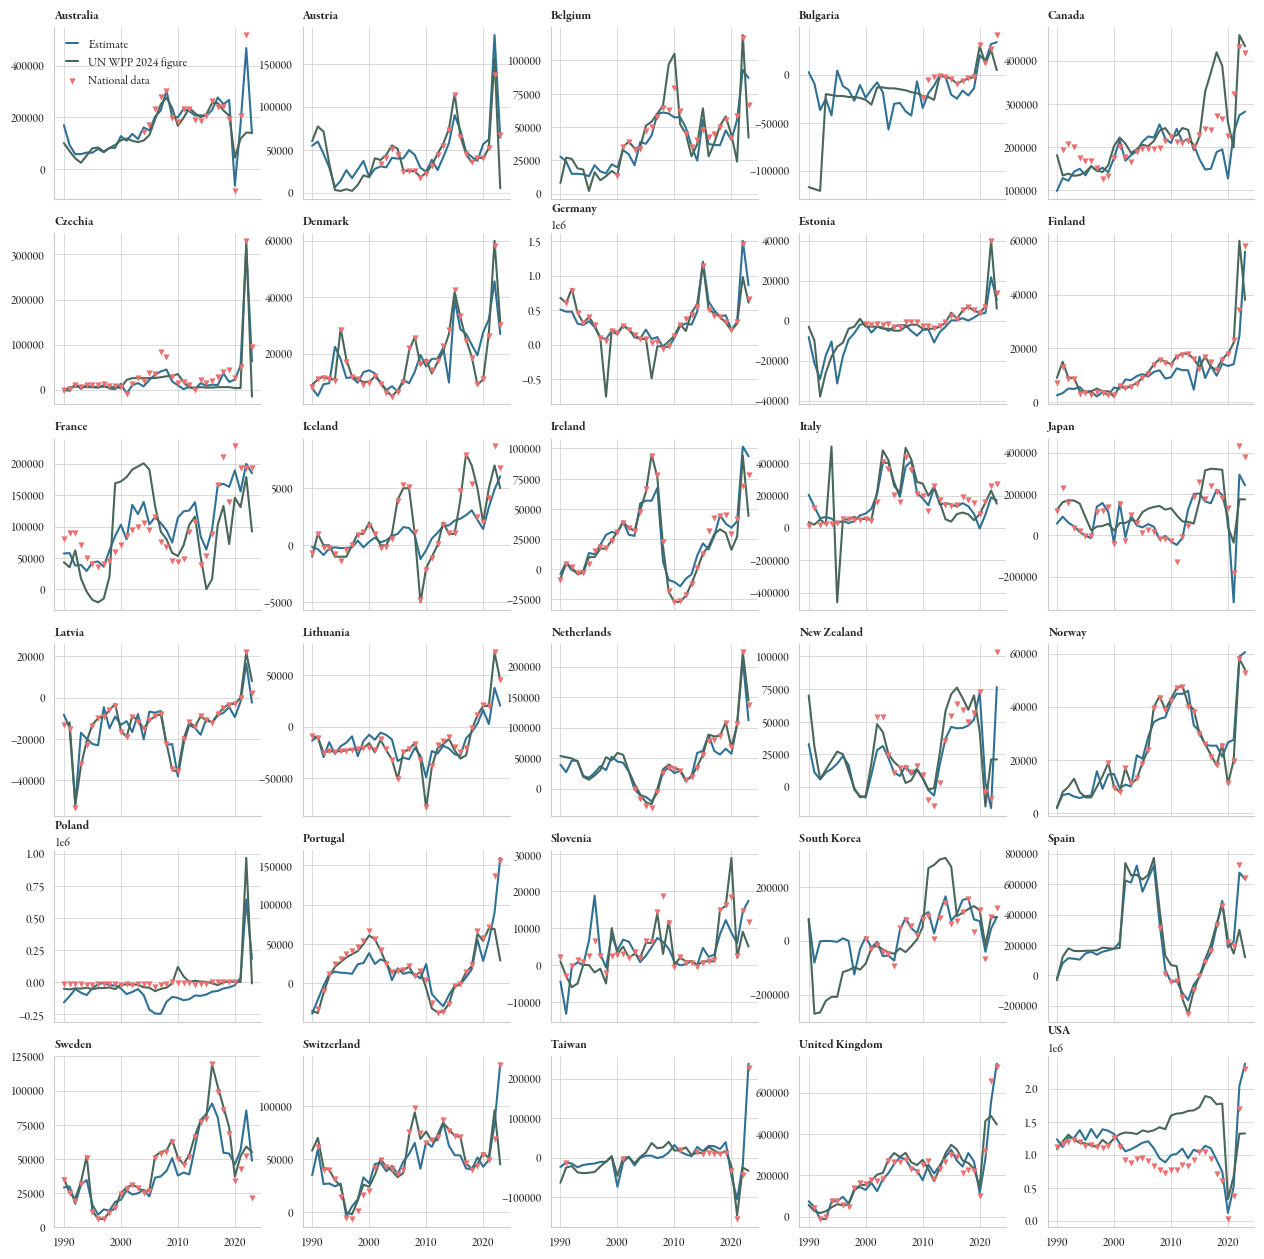

In [10]:
# Compare some net migration estimates
fig, axs = plt.subplots(nrows=6, ncols=5, sharex=True, sharey=False, figsize=(12, 12))
for idx, c in enumerate(NatStat_net_migration.coords['Country ISO']):

    predictions['mu_pred'].sel({"Country ISO": c}, drop=True).plot(ax=axs.flatten()[idx], label='Estimate')
    WPP_net_migration.sel({"Country ISO": c, "Year": range(1990, 2024)}, drop=True).plot(ax=axs.flatten()[idx], c='C2', label='UN WPP 2024 figure')
    NatStat_net_migration.sel({"Country ISO": c, "Year": range(1990, 2024)}, drop=True).plot.scatter(ax=axs.flatten()[idx], lw=0, marker='v', s=20, c='C1', label='National data', zorder=2)
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(c)}', x=0, ha='left', weight='bold')
    axs.flatten()[idx].set(xlabel=None, ylabel=None)

axs[0, 0].legend()

## Example: uncertainty quantification by sampling inputs
There are two sources of uncertainty: the uncertainty on the inputs and the degree to which the problem is ill-posed. The second source we estimate by training an ensemble of networks. Their output has been saved in the `Estimates` folder. To estimate the effect of uncertainty on the inputs on the predictions, we could sample the untransformed inputs, transform, and insert into the model. Sampling needs to occur before transforming because $\psi(\lambda x) \neq \lambda \psi(x)$.

Here we illustrate the principle, by using a standard deviation of 5% on all covariates except the stock data, where we use 10%. Binary covariates are not sampled.

In [11]:
# Transformation parameters, as well as a sampling std for each covariate
transformation_parameters = dict((k, {'transformation_parameters': data["transformation_parameters"][k], 'sample_std': 0.05}) for k in data["transformation_parameters"].keys())
transformation_parameters.update(**{"Linguistic_similarity": {'sample_std': 0.05}, "Religious_similarity": {'sample_std': 0.05}})

In [12]:
# Build some samples
samples = utils.generate_samples(data, predictions, n_samples=5, cfg=cfg, transformation_parameters=transformation_parameters, stock_std=0.1, device=device, show_pbar=True)

# Add an offset to the mean
samples['S_sample']['mean'] += utils.get_stock_offsets(
    stock_predictions=samples['S_sample']['mean'].sel({"Year": stock_data.coords['Year']}),
    stock_data=stock_data['Start of year estimate'],
    weights=stock_data['Weight'].fillna(0),
    gamma=gamma
)

100%|██████████| 5/5 [00:47<00:00,  9.59s/it]


Let us take a look at how this changes the flow estimates:

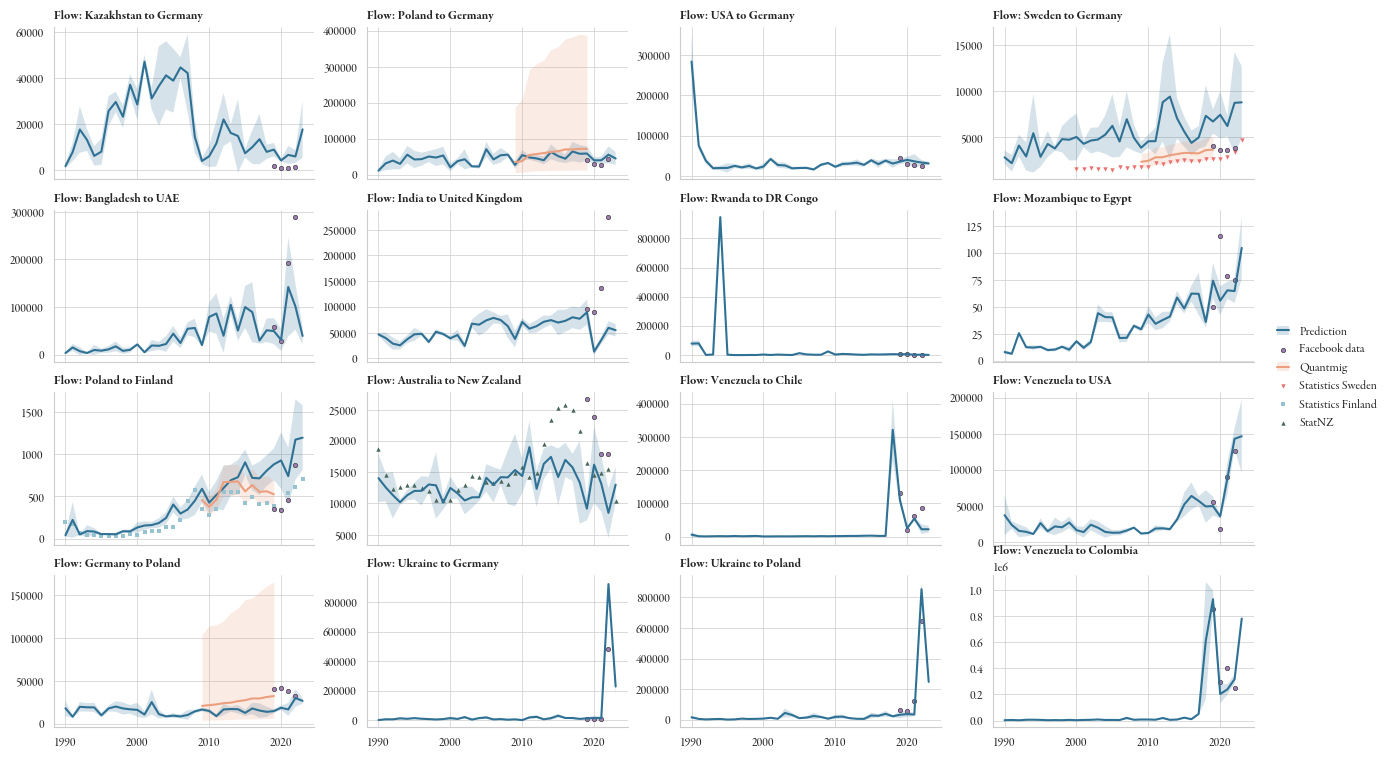

In [13]:
# Compare some flows
fig, axs = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(12, 7))

# Track handles and labels for the figure legend
handles = {}
for idx, (o, d) in enumerate([("KAZ", "DEU"), ("POL", "DEU"), ("USA", "DEU"), ("SWE", "DEU"), ("BGD", "ARE"), ("IND", "GBR"), ("RWA", "COD"), ("MOZ", "EGY"), ("POL", "FIN"), ("AUS", "NZL"), ("VEN", "CHL"), ("VEN", "USA"), ("DEU", "POL"), ("UKR", "DEU"), ("UKR", "POL"), ("VEN", "COL")]):

    _h1 = putils.errorband(samples['F_sample'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    handles['Prediction'] = _h1
    handles.update(putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d))

# Add a legend
fig.legend(list(handles.values()), list(handles.keys()), bbox_to_anchor=(1.01, 0.5), loc='center left')

# Model sensitivity
The goal of the elasticity analysis is to gauge how sensitive the model predictions are to *relative* changes in each input covariate $x_i$, assuming the other covariates are held constant. To do this, we calculate the derivative $$\left\vert \dfrac{x_i}{{T}} \dfrac{\partial {T}}{\partial {x_i}}\right\vert = \left\vert \dfrac{\partial \log {T}}{\partial{x_i}}\right\vert \vert x_i \vert  = \left\vert \dfrac{\partial u_\theta}{\partial {x_i}} \right\vert \vert x_i\vert.$$ Since we are again interested in the sensitivity on the untransformed input variables, we use the chain rule: let $\chi_i$ = $\psi_\lambda(x_i)$; then $$\left\vert \dfrac{\partial u_\theta}{\partial {x_i}} \right\vert= \left\vert \dfrac{\partial u_\theta}{\partial {\chi_i}} \dfrac{\partial \psi}{\partial {x_i}}\right\vert$$ Using the fact that $\psi(-x) = -\psi(x)$, it is sufficient to calculate the last derivative on the absolute value of $x$.


In [14]:
# Matrix of elasticity samples, and associated covariate labels
elasticities, labels = utils.get_elasticities(data, predictions, cfg, n_edges=100000, n_years=5, device=device)
elasticities = abs(elasticities).cpu()

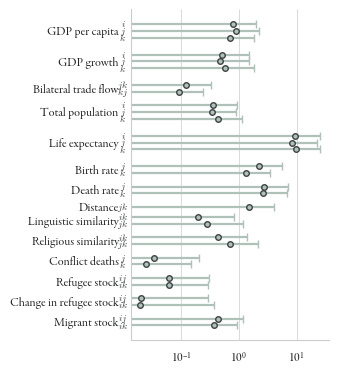

In [16]:
fig, ax = plt.subplots(figsize=(page_width/2, page_width/2))

# Group titles for publication plot
group_titles = {
    'GDP cap': 'GDP per capita',
    'Population': 'Total population',
    'Refugees': 'Refugee stock',
    'Refugees diff': 'Change in refugee stock',
    'Stock': 'Migrant stock',
    'Trade': 'Bilateral trade flow'
}

# Sort the elasticities into groups
elasticity_dict = {}
for idx in range(elasticities.shape[1]):
    group = (labels[idx].split('$')[0])
    if group not in elasticity_dict.keys():
        elasticity_dict[group] = {}
    subgroup = labels[idx].split('{')[-1].replace('}$', '')
    elasticity_dict[group][subgroup] = torch.mean(elasticities[:, idx]), torch.std(elasticities[:, idx])

# Plot the elasticities by group
y0 = len(elasticity_dict.keys())
yticks_pos = []
yticks_labels = []
group_y = []
group_labels = []
for i, (group, val) in enumerate(elasticity_dict.items()):
    group_y.append(y0 -len(val)/2 * 0.3)
    group_labels.append(group_titles.get(group, group))
    for j, subgroup in enumerate(val.keys()):
        ax.errorbar(x=val[subgroup][0], xerr=val[subgroup][1], y=y0-j*0.3, markersize=4, lw=1.6, marker='o', markeredgecolor=colors['c_darkgrey'], markeredgewidth=1, capsize=3, capthick=2, c=colors['c_lightgrey'])
        yticks_pos.append(y0-j*0.3)
        yticks_labels.append(f'${subgroup}$')
    y0-=len(val)*1.5*0.3

# Axis formatting
ax.set_xscale('log')
ax.set_yticks(yticks_pos, yticks_labels, fontsize=7, color=colors['c_darkgrey'], ha='center', va='center')
ax.tick_params(axis='y', which='major', pad=2)
for idx in range(len(group_y)):
    ax.text(ax.get_xlim()[0]-0.005, group_y[idx], group_labels[idx], ha='right')
fig.subplots_adjust(left=0.4)
ax.grid(axis='y')

fig.savefig(f"{img_dir}/elasticities.pdf", pad_inches=0)

If you are done with this section, you can delete the previous estimates to free up some memory. This might be advisable, depending on your system capacity.

In [17]:
del samples
del predictions

# Evaluation of the full model

Now let us evaluate the predictions made by the family of trained neural networks. The estimates are also located in the `Estimates` folder.

In [31]:
# Load the predictions
predictions = dict(
    T_pred = xr.open_dataset("Estimates/T.nc"),
    F_pred = xr.open_dataset("Estimates/flows.nc"),
    mu_pred = xr.open_dataset("Estimates/net_migration.nc"),
    S_pred = xr.open_dataset("Estimates/stocks.nc")
)

Let's again look at some stocks, flows, and net migration estimates.

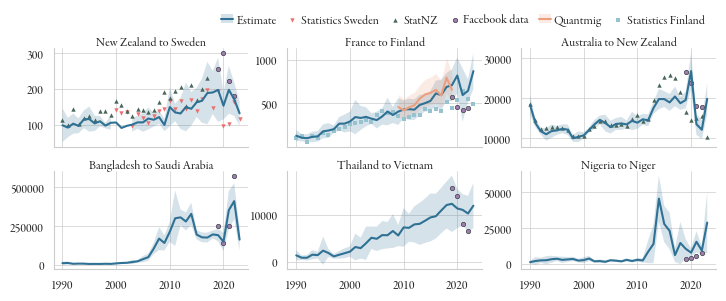

In [19]:
# Plot an example pane
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/3), sharex=True, gridspec_kw={'hspace': 0.25})

handles = {}
for idx, (o, d) in enumerate([("NZL", "SWE"), ("FRA", "FIN"), ("AUS", "NZL"), ("BGD", "SAU"), ("THA", "VNM"), ("NGA", "NER")]):
    _h1 = putils.errorband(predictions['F_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    handles['Estimate'] = _h1
    handles.update(**putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d))
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', x=0.5, ha='center', y=0.95)

fig.legend(handles=list(handles.values()), labels=list(handles.keys()), bbox_to_anchor=(1, 1.05), loc='lower right', columnspacing=0.8, ncols=6, handletextpad=0.2)

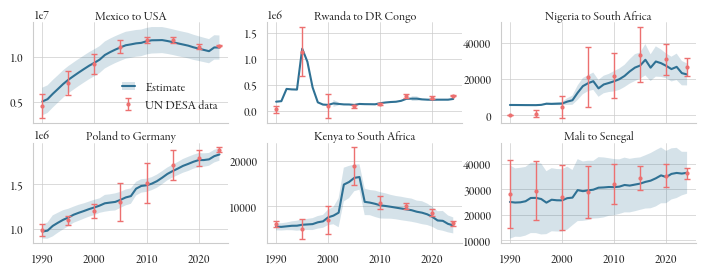

In [20]:
# Comparison of stocks
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/3), sharex=True)

for idx, (o, d) in enumerate([("MEX", "USA"), ("RWA", "COD"), ("NGA", "ZAF"), ("POL", "DEU"), ("KEN", "ZAF"), ("MLI", "SEN")]):
    _h1 = putils.errorband(predictions['S_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    _h2 = putils.errorbar(stock_data.sel({"Origin ISO": o, "Destination ISO": d}, drop=True), axs.flatten()[idx], y='2025 Revision', yerr='Error', lw=0, elinewidth=1, capsize=2, markersize=2, marker='o', zorder=2)
    axs.flatten()[idx].set(xlabel=None, ylabel=None)
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', y=0.95)
axs[0, 0].legend(handles=[_h1, _h2], labels=['Estimate', 'UN DESA data'])

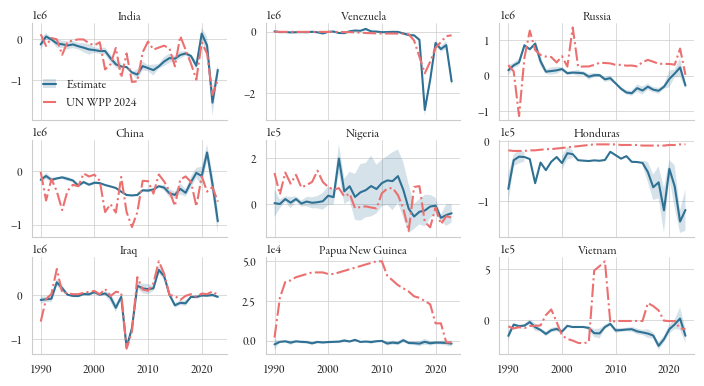

In [21]:
# Comparison of net migration
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(page_width, page_width/2), sharex=True)
for idx, c in enumerate(['IND', 'VEN', 'RUS', 'CHN', 'NGA', 'HND', 'IRQ', 'PNG', 'VNM']):
    _h1 = putils.errorband(predictions['mu_pred'].sel({"Country ISO": c}), axs.flatten()[idx])
    _h2 = WPP_net_migration.sel({"Country ISO": c, "Year": range(1990, 2024)}).plot(ax=axs.flatten()[idx], ls='-.')
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(c)}', y=0.95)
    axs.flatten()[idx].set(xlabel=None, ylabel=None)
    axs.flatten()[idx].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
axs[0, 0].legend(handles=[_h1, _h2[0]], labels=['Estimate', 'UN WPP 2024'])

# fig.savefig(f"{img_dir}/net_migration_examples.pdf", pad_inches=0)

We can look at total in- and outflows for each region, as well as the nets. We can also look at the total intra-regional flows

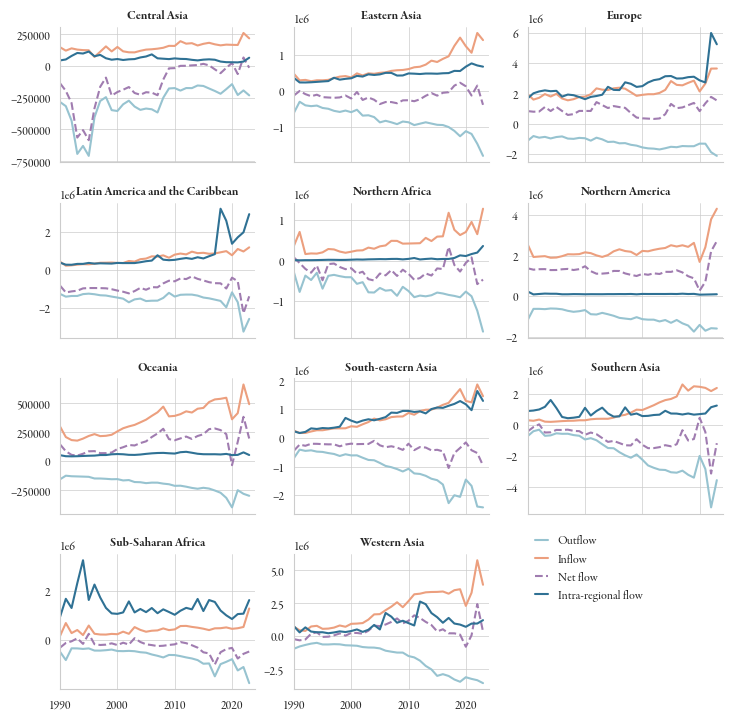

In [22]:
fig, axs = plt.subplots(ncols=3, nrows=4, sharex=True, sharey=False, figsize=(page_width, page_width), gridspec_kw={'hspace': 0.3})

for idx, region in enumerate(countries_by_region.keys()):

    # Out-, in-flow, and nets
    out_flow = predictions['F_pred']['mean'].sel({
        "Origin ISO": countries_by_region[region], "Destination ISO": np.concat([countries_by_region[k] for k in countries_by_region.keys() if k != region])
    }).sum(['Origin ISO', 'Destination ISO'])
    in_flow = predictions['F_pred']['mean'].sel({
        "Destination ISO": countries_by_region[region], "Origin ISO": np.concat([countries_by_region[k] for k in countries_by_region.keys() if k != region])
    }).sum(['Origin ISO', 'Destination ISO'])
    (-1*out_flow).plot(ax=axs.flatten()[idx], label='Outflow' if idx == 0 else None, c=colors['c_lightblue'])
    in_flow.plot(ax=axs.flatten()[idx], label='Inflow' if idx == 0 else None, c=colors['c_orange'])
    (in_flow - out_flow).plot(ax=axs.flatten()[idx], label='Net flow' if idx == 0 else None, c=colors['c_purple'], ls='dashed')

    # Intra-regional flow
    intra_flow = predictions['F_pred']['mean'].sel({
        "Origin ISO": countries_by_region[region], "Destination ISO": countries_by_region[region]
    }).sum(['Origin ISO', 'Destination ISO'])
    intra_flow.plot(ax=axs.flatten()[idx], label='Intra-regional flow' if idx == 0 else None,)

    # Titles and Labels
    axs.flatten()[idx].set_title(region, x=.50, weight='bold', ha='center')
    axs.flatten()[idx].set(xlabel=None, ylabel=None, xlim=(1990, 2024))

axs[-1, -1].axis('off')
fig.legend(bbox_to_anchor=(0.7, 0.25), loc='upper left')

We can also look at the volume of flows within regions. Europe has the largest intra-regional flow.

[Text(0.5, 0, ''), Text(0, 0.5, '')]

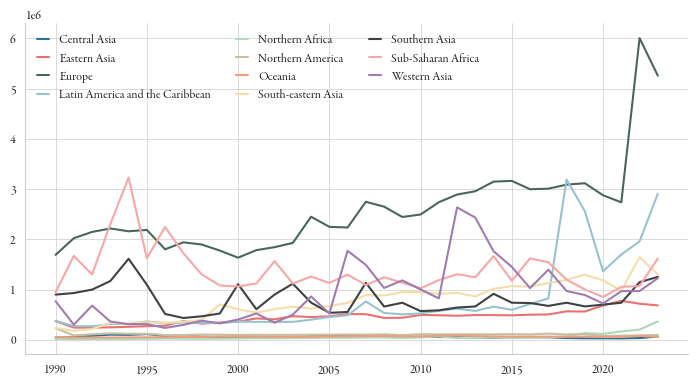

In [23]:
fig, ax = plt.subplots(figsize=(page_width, page_width/2))
for idx, region in enumerate(countries_by_region.keys()):
    intra_flow = predictions['F_pred']['mean'].sel({"Origin ISO": countries_by_region[region], "Destination ISO": countries_by_region[region]}).sum(['Origin ISO', 'Destination ISO'])
    intra_flow.plot(ax=ax, label=region)
ax.legend(ncols=3)
ax.set(xlabel=None, ylabel=None)

Here's the plot from the publication, showing also the total global flows.

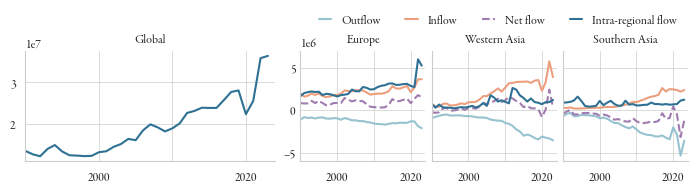

In [24]:
fig, axs = plt.subplots(ncols=5, nrows=1, sharex=True, sharey=False, figsize=(page_width, page_width/6), gridspec_kw={'wspace': 0.05, 'width_ratios': [2, 0.1, 1, 1, 1]})

for idx, region in enumerate(['', '', 'Europe', 'Western Asia', 'Southern Asia']):
    if idx < 2:
        continue
    # In-, out-flow and net flow
    out_flow = predictions['F_pred']['mean'].sel({"Origin ISO": countries_by_region[region], "Destination ISO": np.concatenate([countries_by_region[k] for k in countries_by_region.keys() if k != region])}).sum(['Origin ISO', 'Destination ISO'])
    in_flow = predictions['F_pred']['mean'].sel({"Destination ISO": countries_by_region[region], "Origin ISO": np.concatenate([countries_by_region[k] for k in countries_by_region.keys() if k != region])}).sum(['Origin ISO', 'Destination ISO'])
    (-1*out_flow).plot(ax=axs.flatten()[idx], label='Outflow' if idx == 2 else None, c=colors['c_lightblue'])
    in_flow.plot(ax=axs.flatten()[idx], label='Inflow' if idx == 2 else None, c=colors['c_orange'])
    (in_flow - out_flow).plot(ax=axs.flatten()[idx], label='Net flow' if idx == 2 else None, c=colors['c_purple'], ls='dashed')

    # Intra-regional flow
    intra_flow = predictions['F_pred']['mean'].sel({"Origin ISO": countries_by_region[region], "Destination ISO": countries_by_region[region]}).sum(['Origin ISO', 'Destination ISO'])
    intra_flow.plot(ax=axs.flatten()[idx], label='Intra-regional flow' if idx == 2 else None,)

    # Titles and labels
    axs.flatten()[idx].set_title(region, x=.50, y=1, ha='center')
    axs.flatten()[idx].set(xlabel=None, ylabel=None, xlim=(1990, 2024), ylim=(-6e6, 7e6))
    if idx > 2:
        axs.flatten()[idx].set_xticks([1990, 2000, 2010, 2020], labels=['', 2000, '', '2020'])
        axs[idx].tick_params(axis='y', labelleft=False)
    axs[idx].tick_params(axis='y', pad=0)

axs[1].axis('off')
predictions['F_pred']['mean'].sum(["Origin ISO", "Destination ISO"]).plot(ax=axs[0])
axs[0].set(xlabel=None, ylabel=None, xlim=(1990, 2024), title='Global')
fig.legend(bbox_to_anchor=(1, 1.12), loc='lower right', ncols=4)

#fig.savefig(f"{img_dir}/regional_flows.pdf", pad_inches=0)

# Performance evaluation
## Comparison with other methods
Let us look at how the model's predictions compare to the five-year flow estimates of other methods.

In [25]:
# Five-year flow estimates from other methods
five_year_flows = xr.load_dataset("Data/Flow_data/five_year_flows.nc")

# Five-year net migration estimates from the WPP
mu_5y_WPP = utils.aggregate(
    xr.load_dataset("Data/UN_WPP_data/UN_WPP_data.nc")['Net Number of Migrants (thousands)'].sel({"Year": range(1990, 2024)}) * 1000, np.arange(1990, 2021, 5)
)

# Five-year net migration estimates from other sources
mu_5y = xr.open_dataarray("Data/Flow_data/five_year_net_migration.nc")

In [26]:
# Calculate the five-year flows
five_year_flows_neural = utils.aggregate_T(predictions['T_pred']['mean'], np.arange(1990, 2021, 5))

In [27]:
# Calculate the evaluation metrics for the comparison methods and each neural network instance
stats = putils.comparison_stats(five_year_flows.sel({"Collection": ['Demig C2C', 'Eurostat', 'UN DESA IMFSC', 'ILO ASEAN'], "Coverage": "total"}), population)
neural_stats = putils.comparison_stats(
    putils.align_five_year_flows(five_year_flows, five_year_flows_neural).assign_coords({"Method": ['Neural']}).sel({"Collection": ['Demig C2C', 'Eurostat', 'UN DESA IMFSC', 'ILO ASEAN'], "Coverage": "total"}), population
)
stats = xr.concat([stats, neural_stats], dim='Method')
del neural_stats

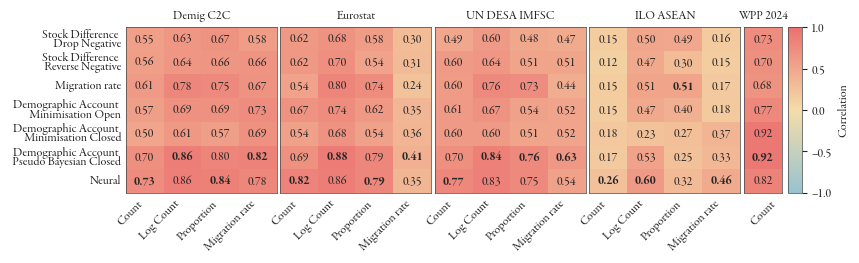

In [28]:
fig, axs = plt.subplots(ncols=5, sharex=False, sharey=True, gridspec_kw={'width_ratios': [4, 4, 4, 4, 1]}, figsize=(page_width, page_width/4))

# ColorManager for the heatmap
cm = ColorManager(cmap={'continuous': True, 'over': colors['c_purple'], 'from_values': {0: colors['c_lightblue'], 0.5: colors['c_yellow'], 1: colors['c_red']}}, vmin=-1, vmax=1)

# Plot the evaluation metrics
putils.plot_eval_metrics(stats, fig, axs, cm=cm)

# Plot the correlation on the UN WPP data
putils.plot_grid_to_ax(
    xr.concat([xr.corr(mu_5y, mu_5y_WPP, dim=['Country ISO', 'Year0']),
               xr.corr(
                   utils.aggregate(predictions['mu_pred']['mean'], mu_5y_WPP.coords['Year0'].data), mu_5y_WPP
               ).expand_dims({"Method": ['Neural']})], dim='Method').data.reshape(-1, 1), axs[-1], cm=cm)
axs[-1].set_xticks([0], ['Count'], ha='center', rotation=45)
axs[-1].set_title('WPP 2024')
axs[0].set_yticks(ticks=axs[0].get_yticks(), labels=axs[0].get_yticklabels(), linespacing=0.7, va='center')
for ax in axs:
    ax.tick_params('both', length=0)

#fig.savefig(f"{img_dir}/performance_comparison.pdf", pad_inches=0)

These correlations are on the entire dataset, rather than along each individual flow corridor. Let's look at the correlation of the predicted flows against the various datasets, looking at the correlation along each corridor:

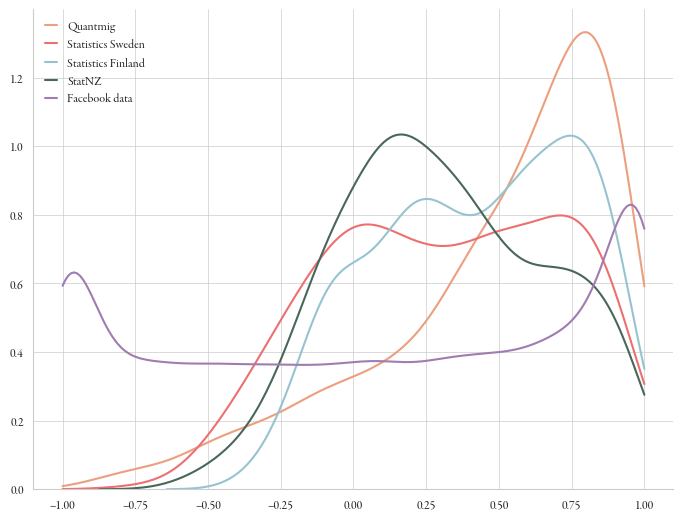

In [29]:
fig, ax = plt.subplots()
for key in flow_dsets.keys():
    if key == 'Facebook':
        continue
    y = flow_dsets[key]['data']
    if 'central' in flow_dsets[key].keys():
        y = y[flow_dsets[key]['central']]
    sns.kdeplot(
        xr.corr(
            predictions['F_pred']['mean'].sel(**flow_dsets[key]['data'].coords),
            y, dim='Year').data.flatten(), ax=ax, c=flow_dsets[key]['primary_color'], label=key, clip=[-1, 1]
    )
ax.set(ylabel=None)
ax.legend()

## Performance on test edges
We can look at how well the neural networks have fared on the test data.

In [32]:
# Load the estimates of the network on the test flows, as well the mask used to select them
mask = xr.DataArray(torch.load("Trained_networks/z_100_yj_05_eta_10/FlowTestMask.pt", weights_only=True),
                    dims=['Year', 'Origin ISO', 'Destination ISO'], coords=predictions['F_pred'].coords)
test_flows = xr.open_dataset("Estimates/test_flows.nc")

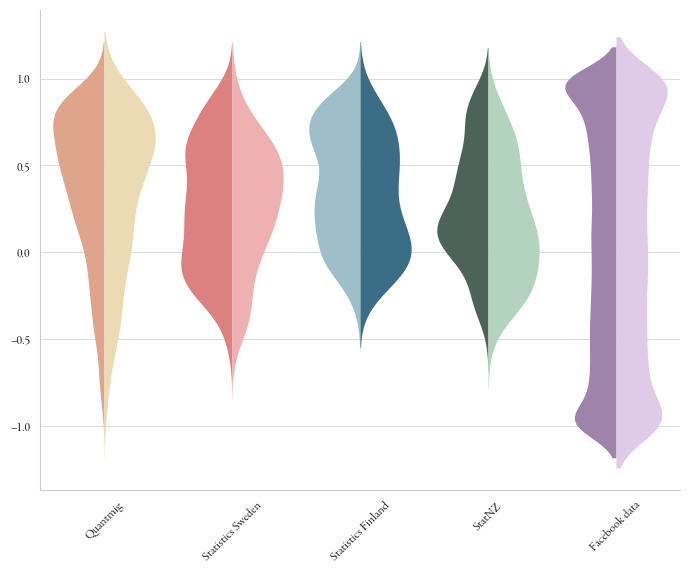

In [33]:
fig, ax = plt.subplots()
putils.correlation_violin(ax, pred=test_flows['mean'], mask=mask, items=flow_dsets)
ax.tick_params(axis='x', labelrotation=45)

Additionally, we should check how well the uncertainties on our estimates matche those on the Quantmig data and the UN stock estimates.

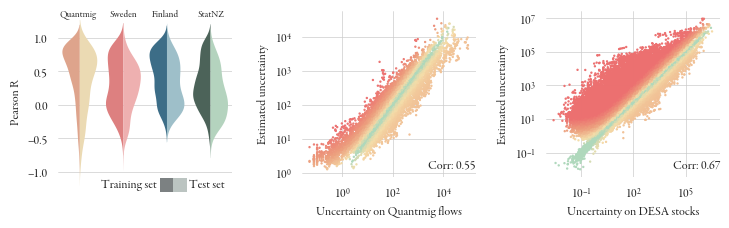

In [34]:
fig, axs = plt.subplots(ncols=3, figsize=(page_width, page_width/4))

for label, item in flow_dsets.items():
    if label == 'Facebook data':
        continue

    # Compute correlations
    ds = item['data']
    if 'central' in item.keys():
        ds = ds[item['central']]

    corr_train = xr.corr(ds.where(~mask), predictions['F_pred']['mean'].where(~mask), dim='Year').data.flatten()
    corr_test = xr.corr(ds.where(mask), test_flows['mean'].where(mask), dim='Year').data.flatten()

    # Build a DataFrame
    df = pd.DataFrame({
        'group': [label] * (len(corr_train) + len(corr_test)),
        'subgroup': ['Train'] * len(corr_train) + ['Test'] * len(corr_test),
        'value': np.concatenate([corr_train, corr_test])
    })

    # Plot
    kwargs = dict(split=True, fill=True, inner=None, gap=0., linewidth=0, legend=False)
    #kwargs.update(**plot_kwargs)
    sns.violinplot(df, x="group", y="value", hue="subgroup", ax=axs[0],
                   palette=dict(Train=item['primary_color'], Test=item['secondary_color']) if label!='Statistics Finland' else dict(Test=item['primary_color'], Train=item['secondary_color']), **kwargs)
axs[0].tick_params(axis='x', labelbottom=False)
axs[0].set(xlabel=None, ylabel=None)
axs[0].text(0.12, 0.97, 'Quantmig', transform=axs[0].transAxes, ha='center', fontsize=7)
axs[0].text(0.38, 0.97, 'Sweden', transform=axs[0].transAxes, ha='center', fontsize=7)
axs[0].text(0.62, 0.97, 'Finland', transform=axs[0].transAxes, ha='center', fontsize=7)
axs[0].text(0.88, 0.97, 'StatNZ', transform=axs[0].transAxes, ha='center', fontsize=7)

legend_box = fig.add_axes([0.15, -0.2, 0.1, 0.3])
legend_box.axis('off')
legend_box.set_xlim(0, 2)
legend_box.scatter([0.3], [1], s=100, marker='s', lw=0, color='#7C8182')
legend_box.scatter([0.7], [1], s=100, marker='s', lw=0,  color='#BBC4C1')
legend_box.text(0., 0.5, 'Training set', ha='right', va='center', transform=legend_box.transAxes)
legend_box.text(0.48, 0.5, 'Test set', ha='left', va='center', transform=legend_box.transAxes)

axs[0].set(ylabel="Pearson R")
for ax in axs:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

x=0.25*(flow_dsets['Quantmig']['data']['flow_97.5%'] - flow_dsets['Quantmig']['data']['flow_2.5%'])
y=predictions['F_pred']['std'].sel(**flow_dsets['Quantmig']['data'].coords)
axs[1].text(1, 0.05, f"Corr: {xr.corr(x, y).item():>.2f}", transform=axs[1].transAxes, ha='right')

# ColorManager for the relative errors
cm = ColorManager(cmap={'continuous': True, 'over': colors['c_red'], 'under': colors['c_lightgreen'], 'from_values': {0: colors['c_lightgreen'], 0.33: colors['c_yellow'], 0.66: colors['c_orange'], 1: colors['c_red']}}, vmin=1e-1, vmax=10, norm='LogNorm')

putils.scatter_relative_errs(x, y, axs[1], cm=cm, s=0.5)
axs[1].set(yscale='log', xscale='log', xlabel='Uncertainty on Quantmig flows', ylabel='Estimated uncertainty')

x=stock_data['Error']
y=predictions['S_pred']['std'].sel(**stock_data.coords)
axs[2].text(1, 0.05, f"Corr: {xr.corr(x, y).item():>.2f}", transform=axs[2].transAxes, ha='right')

putils.scatter_relative_errs(x, y, axs[2], cm=cm, s=0.5)
axs[2].set(yscale='log', xscale='log', xlabel='Uncertainty on DESA stocks', ylabel='Estimated uncertainty')

fig.subplots_adjust(wspace=0.4)

# Shift the left axis down a little
pos = axs[0].get_position()  # Get current [left, bottom, width, height]
new_pos = [pos.x0, pos.y0 - 0.1, pos.width, pos.height*1.1]  # Shift downward
axs[0].set_position(new_pos)

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# fig.savefig(f"{img_dir}/performance_comparison_3.png", pad_inches=0)

## Compare with other net migration estimates
We plot the correlation over time of our net migration estimates against the UN WPP:

100%|██████████| 242/242 [00:01<00:00, 132.19it/s]


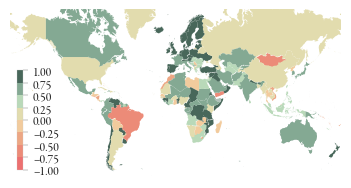

In [35]:
# Prepare the world plot
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Mercator()), figsize=(page_width/2, page_width/2))
patches = putils.add_country_patches(world, ax, lw=0, facecolor=colors['c_lightgrey'])
ax.set_extent([-180, 180, -60, 73])
ax.axis('off')

# Plot the correlation
cm = ColorManager(cmap={'continuous': True, 'bad': colors['c_lightgrey'], 'from_values': {0: colors['c_red'], 0.25: colors['c_orange'], 0.5: colors['c_yellow'], 0.75: colors['c_lightgreen'], 1: colors['c_darkgreen']}}, vmin=-1, vmax=1, norm=dict(name='BoundaryNorm', ncolors=256, boundaries=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]))
putils.plot_to_map(xr.corr(WPP_net_migration, predictions['mu_pred']['mean'], dim='Year'), fig, patches, cm=cm, add_cbar=False)
cbar = putils.add_cbar_to_map(fig, cm, cbar_loc=[0.02, 0.27, 0.02, 0.3])
cbar.ax.tick_params(axis='y', which='minor', length=0, width=0)

In [57]:
# fig.savefig(f"{img_dir}/net_migration_corr.pdf", pad_inches=0)

We can also look at the median relative error:

100%|██████████| 242/242 [00:01<00:00, 131.95it/s]


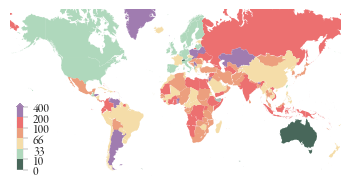

In [37]:
# Prepare the world plot
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Mercator()), figsize=(page_width/2, page_width/2))
patches = putils.add_country_patches(world, ax, lw=0, facecolor=colors['c_lightgrey'])
ax.set_extent([-180, 180, -60, 73])
ax.axis('off')

# Plot the median relative error
cm = ColorManager(
    norm=dict(name='BoundaryNorm', ncolors=6, boundaries=[0, 10, 33, 66, 100, 200, 400]), vmin=0, vmax=200, cmap={'continuous': False, 'over': colors['c_purple'], 'from_values': {0: colors['c_darkgreen'], 0.25: colors['c_lightgreen'], 0.5: colors['c_yellow'], 0.75: colors['c_orange'], 0.8: colors['c_red'], 1: colors['c_purple']}}
)
putils.plot_to_map(100*(abs(WPP_net_migration - predictions['mu_pred']['mean'])/abs(WPP_net_migration)).median('Year'), fig, patches, norm='LogNorm', cm=cm, add_cbar=False)
cbar = putils.add_cbar_to_map(fig, cm, cbar_loc=[0.02, 0.27, 0.02, 0.2], extend='max')
cbar.ax.tick_params(axis='y', which='minor', length=0, width=0)

We also show the uncertainty on the net migration estimates for each country:

100%|██████████| 242/242 [00:01<00:00, 131.47it/s]


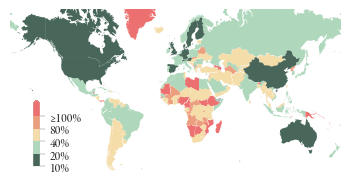

In [38]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Mercator()), figsize=(page_width/2, page_width/2))
patches = putils.add_country_patches(world, ax, lw=0, facecolor=colors['c_lightgrey'])
ax.set_extent([-180, 180, -60, 73])
ax.axis('off')

# Plot the relative uncertainty
rel_unc =( predictions['mu_pred']['std'] / abs(predictions['mu_pred']['mean'])).median('Year')
cm = ColorManager(cmap={'continuous': True, 'over': colors['c_red'], 'from_values': {0: colors['c_darkgreen'], 0.25: colors['c_lightgreen'], 0.5: colors['c_yellow'], 0.75: colors['c_orange'], 1: colors['c_red']}}, vmin=rel_unc.min(), vmax=rel_unc.max(), norm=dict(name='BoundaryNorm', ncolors=256, boundaries=[0.1, 0.2, 0.4, 0.8, 1, 2]))
putils.plot_to_map(rel_unc, fig, patches, cm=cm, add_cbar=False)
cbar = putils.add_cbar_to_map(fig, cm, cbar_loc=[0.07, 0.28, 0.02, 0.2], extend='max')
cbar.set_ticks([0.1, 0.2, 0.4, 0.8, 1], labels=['10%', '20%', '40%', '80%', '≥100%'])
cbar.ax.tick_params(axis='y', which='minor', length=0, width=0)

In [39]:
# fig.savefig(f"{img_dir}/net_migration_unc.pdf", pad_inches=0)

Let us also visualise some flow predictions on the test set. Below is the list of all the corridors contained in the test set.

In [40]:
print(
    mask.any(dim='Year').stack(edge=['Origin ISO', 'Destination ISO']).where(lambda x: x).dropna('edge').coords['edge'].data.tolist()
)

[('ABW', 'NZL'), ('AFG', 'AZE'), ('AFG', 'BGR'), ('AFG', 'BIH'), ('AFG', 'BRN'), ('AFG', 'BWA'), ('AFG', 'CAN'), ('AFG', 'CIV'), ('AFG', 'COL'), ('AFG', 'CPV'), ('AFG', 'DNK'), ('AFG', 'EGY'), ('AFG', 'GEO'), ('AFG', 'GMB'), ('AFG', 'GNQ'), ('AFG', 'HUN'), ('AFG', 'KWT'), ('AFG', 'LVA'), ('AFG', 'MDV'), ('AFG', 'MKD'), ('AFG', 'NPL'), ('AFG', 'PHL'), ('AFG', 'ROU'), ('AFG', 'SDN'), ('AFG', 'TON'), ('AFG', 'TWN'), ('AFG', 'TZA'), ('AFG', 'VCT'), ('AFG', 'ZMB'), ('AGO', 'BDI'), ('AGO', 'BHR'), ('AGO', 'BRA'), ('AGO', 'CAF'), ('AGO', 'CHL'), ('AGO', 'DEU'), ('AGO', 'DJI'), ('AGO', 'ETH'), ('AGO', 'FSM'), ('AGO', 'GAB'), ('AGO', 'GEO'), ('AGO', 'GNB'), ('AGO', 'GRD'), ('AGO', 'GTM'), ('AGO', 'HND'), ('AGO', 'HTI'), ('AGO', 'IND'), ('AGO', 'IRL'), ('AGO', 'JOR'), ('AGO', 'KGZ'), ('AGO', 'LSO'), ('AGO', 'MDG'), ('AGO', 'MMR'), ('AGO', 'NER'), ('AGO', 'NZL'), ('AGO', 'OMN'), ('AGO', 'PHL'), ('AGO', 'ROU'), ('AGO', 'SEN'), ('AGO', 'STP'), ('AGO', 'SYR'), ('AGO', 'TLS'), ('AGO', 'TTO'), ('AGO',

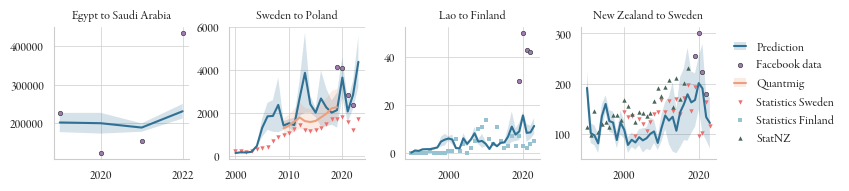

In [41]:
fig, axs = plt.subplots(ncols=4, figsize=(page_width, page_width/5), sharex=False, gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
handles = {}

for idx, (o, d) in enumerate([('EGY', 'SAU'), ('SWE', 'POL'), ('LAO', 'FIN'), ('NZL', 'SWE')]):

    # Plot the predictions
    yrs = flow_data.sel({"Origin ISO": o, "Destination ISO": d}).dropna('Year').coords['Year'].data
    l = putils.errorband(test_flows.sel({"Origin ISO": o, "Destination ISO": d, "Year": yrs}, drop=True), axs.flatten()[idx])
    handles['Prediction'] = l

    # Plot the data
    _h = putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d)
    handles.update(**_h)

    axs[idx].set_title(f"{putils.iso_to_name(o)} to {putils.iso_to_name(d)}", x=0.5)


fig.legend(list(handles.values()), list(handles.keys()), bbox_to_anchor=(1.01, 0.5), loc='center left')

Finally, let's directly compare the stock predictions, flow estimates, and estimates on the test set:

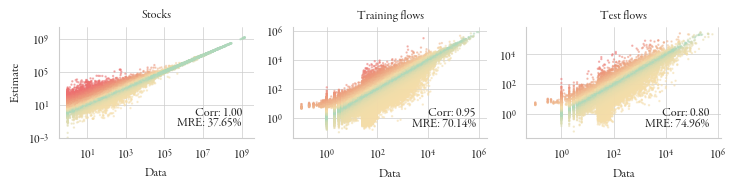

In [42]:
fig, axs = plt.subplots(ncols=3, figsize=(page_width, page_width/6))

# ColorManager for the relative errors
cm = ColorManager(cmap={'continuous': True, 'over': colors['c_red'], 'under': colors['c_lightgreen'], 'from_values': {0: colors['c_lightgreen'], 0.33: colors['c_yellow'], 0.66: colors['c_orange'], 1: colors['c_red']}}, vmin=1e-1, vmax=100, norm='LogNorm')

# Compare relative errors
for idx, (x, y) in enumerate([
    (stock_data['Start of year estimate'], predictions['S_pred']['mean'].sel({"Year": stock_data.coords['Year'].data})),
    (flow_data, predictions['F_pred']['mean']),
    (flow_data.where(mask), test_flows['mean'].where(mask)),
]):

    putils.scatter_relative_errs(x, y, ax=axs[idx], cm=cm, s=0.5, alpha=0.5)
    axs[idx].set(xscale='log', yscale='log')
    # Correlation
    axs[idx].text(0.94, 0.2, f"Corr: {xr.corr(x, y):>.2f}", transform=axs[idx].transAxes, ha='right')
    # Median relative error
    axs[idx].text(0.94, 0.1, f"MRE: {100*np.nanmedian(abs(x-y)/x):>.2f}%", transform=axs[idx].transAxes, ha='right')

axs[0].set(ylim=(1e-3, None), title='Stocks', xlabel='Data', ylabel='Estimate')
axs[1].set(title='Training flows', xlabel='Data')
axs[2].set(title='Test flows', xlabel='Data')
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# fig.savefig(f"{img_dir}/performance_2.png", pad_inches=0)

# Map plots
We can visualise flows on a map, and colour the flows by year.

## Largest flows
First, let's load all the individual flows and sort them in descending order. Each item in this list is a unique (total) flow, which we can plot to a map or a chord diagramme.

In [43]:
largest_flows = putils.get_flow_items(predictions['F_pred']['mean'])
print(largest_flows[:5])

[{'Year': 2019, 'Origin ISO': 'VEN', 'Destination ISO': 'COL', 'Value': 856725.6875}, {'Year': 2022, 'Origin ISO': 'MEX', 'Destination ISO': 'USA', 'Value': 848208.0625}, {'Year': 2022, 'Origin ISO': 'UKR', 'Destination ISO': 'RUS', 'Value': 824761.8125}, {'Year': 1994, 'Origin ISO': 'RWA', 'Destination ISO': 'COD', 'Value': 814977.125}, {'Year': 1994, 'Origin ISO': 'IRN', 'Destination ISO': 'AFG', 'Value': 783382.625}]


We can visualise the top 10.000 flows on a double globe.
> **Warning** running this plot will take a few minutes!

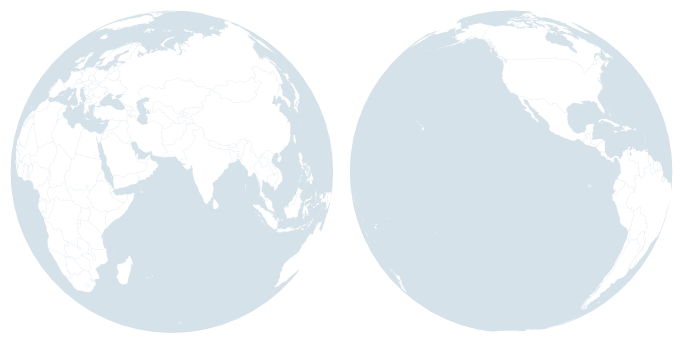

In [44]:
# Create a figure with two globes, using a dark color scheme
fig = plt.figure()
fig.subplots_adjust(wspace=0.05)
axs = np.array([
    fig.add_subplot(121, projection=ccrs.Orthographic(central_longitude=65, central_latitude=20)),
    fig.add_subplot(122, projection=ccrs.Orthographic(central_longitude=-120, central_latitude=5))
    ])

# Add borders
for ax in axs:
    ax.axis('off')
    #ax.set(facecolor='#536E66', alpha=1)
    putils.add_borders(ax, edgecolor=colors['c_darkblue'], alpha=0.2)
    putils.add_ocean(ax, alpha=0.2, color=colors['c_darkblue'])
    #add_gridlines(ax, color=colors['c_darkblue'])

# Get current bounding box of the figure in inches, and set the size to match the page width
bbox = fig.get_tightbbox(fig.canvas.get_renderer())
aspect = bbox.height / bbox.width
fig.set_size_inches(page_width, page_width * aspect)

In [45]:
# Set the colour scheme
cm = ColorManager(cmap={'from_values': {1995: '#85C28C', 2005: colors['c_yellow'], 2015: colors['c_purple'], 2025: colors['c_darkblue']}})

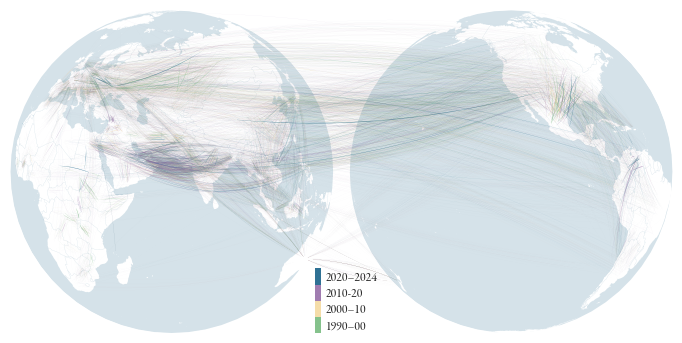

In [46]:
# Clear any previously plotted items
for ax in axs:
    while len(ax.artists) > 1: # do not remove grid
        ax.artists[-1].remove()
    while len(ax.patches) > 0:
        ax.patches[-1].remove()
    while len(ax.collections) > 2:
        ax.collections[-1].remove()
while len(fig.artists) > 0:
    fig.artists[-1].remove()
while len(fig.lines) > 0:
    fig.lines[-1].remove()
while len(fig.axes) > 2:
    fig.axes[-1].remove()

# Plot 10,000 largest flows
for flow in largest_flows[:10000]:

    # Set curvature of South Asia->Middle East flows
    if not (flow['Origin ISO'] in ['IND', 'BGD', 'PHL'] and flow['Destination ISO'] in ['SAU', 'ARE']):
        putils.plot_arrow(fig,
                   coord1=putils.get_random_coord_in_country(fig, flow['Origin ISO'], coordinates=coordinates, jiggle=0.1),
                   coord2=putils.get_random_coord_in_country(fig, flow['Destination ISO'], coordinates=coordinates, jiggle=0.1),
                   mutation_scale=5*1e-6*flow['Value'],
                   connectionstyle='arc3,rad=0.1',
                   arrowstyle='wedge,tail_width=0.05,shrink_factor=2',
                   alpha=0.8,
                   color=cm.map_to_color(flow['Year']),
                   lw=0
                   )
    else:
        putils.plot_arrow(fig, coord1=putils.get_random_coord_in_country(fig, flow['Origin ISO'], coordinates=coordinates, jiggle=0.1 if flow['Origin ISO'] != 'RUS' else 0.01),
           coord2=putils.get_random_coord_in_country(fig, flow['Destination ISO'], coordinates=coordinates, jiggle=0.1 if flow['Destination ISO'] != 'RUS' else 0.01),
           mutation_scale=5*1e-6*flow['Value'],
           connectionstyle='arc3,rad=-0.3',
           arrowstyle='wedge,tail_width=0.05,shrink_factor=2',
           alpha=0.8,
           lw=0,
           color=cm.map_to_color(flow['Year'])
           )

# Add a nice colourbar
cbar_loc = [0.46, 0.0, 0.01, 0.2]
cax = fig.add_axes(cbar_loc)
from matplotlib.colorbar import Colorbar
cbar = Colorbar(
        cax, cmap=cm.cmap, orientation='vertical', location='right', drawedges=False, norm=cm.norm
    )
cbar.ax.tick_params(axis='y', which='both', length=0, width=0)
cbar.set_ticks([1995, 2005, 2015, 2025], labels=['1990–00', '2000–10', '2010-20', '2020–2024'])
cbar.outline.set_linewidth(0)

fig

In [125]:
#fig.patch.set_alpha(0)
# fig.savefig(f"{img_dir}/global_flows.png", pad_inches=0)

Let's plot some large-scale migration movements over time:

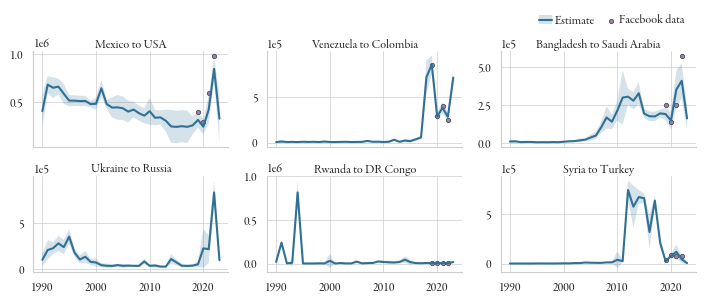

In [47]:
# Plot some individual flows
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/3), sharex=True, gridspec_kw={'hspace': 0.3, 'wspace': 0.2})

handles = {}
for idx, (o, d) in enumerate([("MEX", "USA"), ("VEN", "COL"), ("BGD", "SAU"), ('UKR', 'RUS'), ('RWA', 'COD'), ('SYR', 'TUR')]):
    _h1 = putils.errorband(predictions['F_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    handles['Estimate'] = _h1
    handles.update(**putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d))
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', x=0.5, ha='center', y=0.95)
    axs.flatten()[idx].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
fig.legend(handles=list(handles.values()), labels=list(handles.keys()), bbox_to_anchor=(1, 1.06), loc='lower right', columnspacing=0.8, ncols=6, handletextpad=0.2)

#fig.savefig(f"{img_dir}/shocks_1.pdf", pad_inches=0)

## Europe 1991
Let's map some flows in Eastern Europe in 1991, after the collapse of the Soviet Union.

100%|██████████| 79/79 [00:00<00:00, 256.66it/s]


Text(165419.4092504864, -1432403.417938795, 'Romania to \nItaly: 9792')

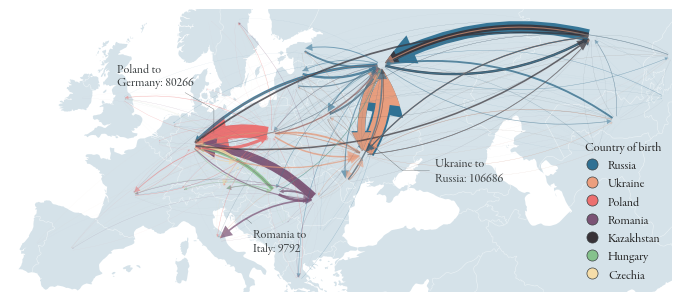

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.Orthographic(central_latitude=55, central_longitude=15))
ax.axis('off')
patches = putils.add_country_patches(
    world.to_crs(ax.projection), ax,
    country_list=np.concatenate([countries_by_region['Europe'], countries_by_region['Western Asia'], countries_by_region['Central Asia'], countries_by_region['Southern Asia'], ['-99']]), facecolor=colors['c_darkblue'], alpha=0.2)
putils.add_borders(ax, edgecolor='#ECF3F6', linewidth=0.5)
ax.set_extent([-10, 70, 37, 50], crs=ccrs.PlateCarree())

# Set birth ISOs and get flow items
birth_iso_list = ['POL', 'UKR', 'RUS', 'KAZ', 'CZE', 'HUN', 'ROU']
flow_items=putils.get_flow_items(predictions['T_pred']['mean'].sel({"Year": 1991, "Birth ISO": birth_iso_list, "Origin ISO": np.concatenate([countries_by_region['Europe'], countries_by_region['Central Asia']]), "Destination ISO": np.concatenate([countries_by_region['Europe'], countries_by_region['Central Asia']])}))[:500]

# Colors to use
color_dict_eu = dict(POL=colors['c_red'],
                    UKR=colors['c_orange'],
                    RUS=colors['c_darkblue'],
                    ROU='#7B5375',
                    KAZ='#383237',
                    HUN='#85C28C',
                    CZE=colors['c_yellow'])
handles = {}
for idx, item in enumerate(flow_items):

    putils.plot_flows(fig,
               flow_items=[item],
               scale=6e-4,
               shrinkA=3, shrinkB=3,
               color_dict=color_dict_eu,
               color_key='Birth ISO',
               alpha=max(0.5, np.exp(-idx/70)),
               zorder=2+idx,
               connectionstyle=f'arc3,rad=0.2',
               arrowstyle='simple' if item['Value'] > 10000 else 'simple,head_length=1.5,head_width=1.5',
               lw=0.,
               special_coords=dict(RUS=(56, 38))
    )
    handles[putils.iso_to_name(item['Birth ISO'])] = Line2D([0], [0], marker='o', lw=0, markeredgewidth=0.5, c=colors['c_darkgrey'], markerfacecolor=color_dict_eu[item['Birth ISO']], markersize=8)

# Get current bounding box of the figure in inches
bbox = fig.get_tightbbox(fig.canvas.get_renderer())
aspect = bbox.height / bbox.width
fig.set_size_inches(page_width, page_width * aspect)

# Add legend
legend = fig.legend(handles=list(handles.values()), labels=list(handles.keys()), title='Country of birth', loc='lower right', bbox_to_anchor=(1, 0.), framealpha=0.)

# Annotate some flows for reference
v = predictions['T_pred']['mean'].sel({'Birth ISO': 'POL', 'Origin ISO': 'POL', 'Destination ISO': 'DEU', 'Year': 1991})
ax.annotate(f'Poland to \nGermany: {v:>.0f}',
            xy=putils.coordinate_to_proj(ax, 52, 12),
            xytext=putils.coordinate_to_proj(ax, 55, -3),
            xycoords=ax.transData,
            zorder=100,
            color=colors['c_darkgrey'],
            arrowprops=dict(arrowstyle="-", connectionstyle="angle,angleA=-30,angleB=90", lw=0.2, color=colors['c_darkgrey']))

v = predictions['T_pred']['mean'].sel({'Birth ISO': 'RUS', 'Origin ISO': 'UKR', 'Destination ISO': 'RUS', 'Year': 1991})
ax.annotate(f'Ukraine to \nRussia: {v:>.0f}',
            xy=putils.coordinate_to_proj(ax, 50, 33),
            xytext=putils.coordinate_to_proj(ax, 45, 40),
            xycoords=ax.transData,
            zorder=100,
            color=colors['c_darkgrey'],
            arrowprops=dict(arrowstyle="-", connectionstyle="angle,angleA=0,angleB=-40", lw=0.2, color=colors['c_darkgrey']))

v = predictions['T_pred']['mean'].sel({'Birth ISO': 'ROU', 'Origin ISO': 'ROU', 'Destination ISO': 'ITA', 'Year': 1991})
ax.annotate(f'Romania to \nItaly: {v:>.0f}',
            xy=putils.coordinate_to_proj(ax, 45, 16),
            xytext=putils.coordinate_to_proj(ax, 42, 17),
            xycoords=ax.transData,
            zorder=100,
            color=colors['c_darkgrey'],
            arrowprops=dict(arrowstyle="-", connectionstyle="angle,angleA=0,angleB=-40", lw=0.2, color=colors['c_darkgrey']))

#fig.savefig(f"{img_dir}/Europe_1991_flows.pdf", transparent=True, pad_inches=0)

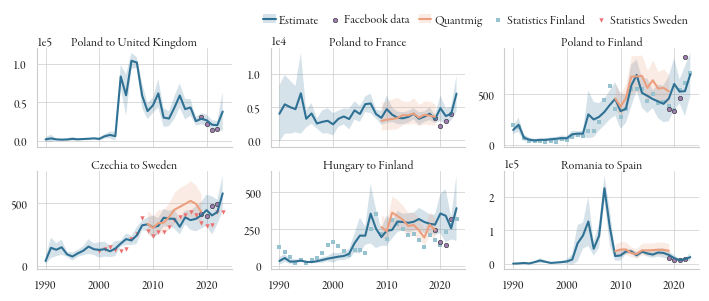

In [12]:
# Plot a flow panel
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/3), sharex=True, gridspec_kw={'hspace': 0.25})

handles = {}
for idx, (o, d) in enumerate([("POL", "GBR"), ("POL", "FRA"), ("POL", "FIN"), ("CZE", "SWE"), ("HUN", "FIN"), ("ROU", "ESP")]):
    _h1 = putils.errorband(predictions['F_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    handles['Estimate'] = _h1
    handles.update(**putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d))
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', x=0.5, ha='center', y=0.95)
    axs.flatten()[idx].ticklabel_format(style='sci', axis='y', scilimits=(1, 3))

fig.legend(handles=list(handles.values()), labels=list(handles.keys()), bbox_to_anchor=(1, 1.05), loc='lower right', columnspacing=0.8, ncols=6, handletextpad=0.2)
#fig.savefig(f"{img_dir}/Europe_flows.pdf", pad_inches=0)

## Sub-Saharan Africa, 2014
Flows in Sub-Sahran Africa in 2014.

100%|██████████| 77/77 [00:00<00:00, 279.64it/s]


Text(1113194.90793274, 1966264.470265134, 'Nigeria to Niger: 44077')

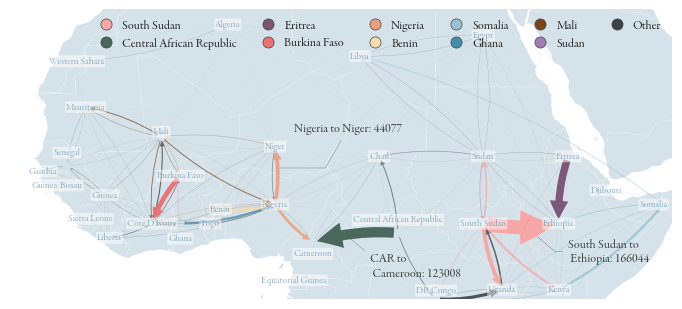

In [13]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Mercator()))
ax.axis('off')
patches = putils.add_country_patches(
    world.to_crs(ax.projection), ax,
    country_list=np.concatenate([countries_by_region['Northern Africa'], countries_by_region['Western Asia'], countries_by_region['Sub-Saharan Africa'], [-99]]), facecolor=colors['c_darkblue'], alpha=0.2)
putils.add_borders(ax, edgecolor='#ECF3F6', linewidth=0.5)
ax.set_extent([-20, 50,0, 25])

while(len(ax.patches)>0):
    ax.patches[-1].remove()
while(len(fig.artists)>0):
    fig.artists[-1].remove()

region = np.concatenate([countries_by_region['Sub-Saharan Africa'], countries_by_region['Northern Africa'], []])
color_dict_afr = dict(
    NGA=colors['c_orange'],
    SOM=colors['c_lightblue'],
    CAF=colors['c_darkgreen'],
    SSD=colors['c_pink'],
    SDN=colors['c_purple'],
    ERI='#7B5375',
    MLI='#7A4419',
    BFA=colors['c_red'],
    GHA='#478DAE',
    BEN=colors['c_yellow']
)

flow_items = putils.get_flow_items(predictions['T_pred']['mean'].sel({"Year": 2014, "Birth ISO": region, "Origin ISO": region, "Destination ISO": region}))[:500]

handles = {}
countries_to_highlight = set()
for idx, item in enumerate(flow_items):

    putils.plot_flows(fig,
               flow_items=[item],
               scale=3e-4,
               shrinkA=3, shrinkB=3,
               color = color_dict_afr.get(item['Birth ISO'], colors['c_darkgrey']),
               alpha=max(0.5, np.exp(-idx/70)),
               zorder=2+idx if item['Birth ISO'] in color_dict_afr.keys() else 2,
               connectionstyle=f'arc3,rad=0.1',
               arrowstyle='simple' if item['Value'] > 20000 else 'simple,head_length=1,head_width=1',
               lw=0.,
               special_coords=dict(RUS=(56, 38))
    )
    if item['Birth ISO'] in color_dict_afr.keys():
        handles[putils.iso_to_name(item['Birth ISO'])] = Line2D([0], [0], marker='o', lw=0, markeredgewidth=0.5, c=colors['c_darkgrey'], markerfacecolor=color_dict_afr.get(item['Birth ISO']), markersize=8)
    countries_to_highlight.add(item['Origin ISO'])
    countries_to_highlight.add(item['Destination ISO'])

handles['Other'] = Line2D([0], [0], marker='o', lw=0, markeredgewidth=0.5, c=colors['c_darkgrey'], markerfacecolor=colors['c_darkgrey'], markersize=8)

putils.highlight_countries(ax, patches, list(countries_to_highlight), patch_kwargs=dict(facecolor=None, ec=None, lw=0, zorder=None), text_kwargs=dict(color=colors['c_darkblue'], fontsize=7, zorder=100, bbox=dict(facecolor='white', alpha=0.5, edgecolor=None, lw=0, boxstyle='round,pad=0.1')), coordinates=coordinates)

# Get current bounding box of the figure in inches
bbox = fig.get_tightbbox(fig.canvas.get_renderer())
aspect = bbox.height / bbox.width
fig.set_size_inches(page_width, page_width * aspect)

# Some manual adjustments to labels
for t in ax.texts:
    if t._text == 'Ghana':
        t._y *= 0.8
    if t._text == 'Senegal':
        t._y *= 1.1
    if t._text == 'Cameroon':
        t._y *= 0.8
    if t._text == 'Central African Republic':
        t._y *= 1.2
    if t._text == 'Mali':
        t._y *= 1.03
    if t._text == 'Somalia':
        t._x *= 0.98
    if t._text == 'Dr Congo':
        t._text = 'DR Congo'
        t._y += 100000

# Add legend
legend = fig.legend(handles=list(handles.values()), labels=list(handles.keys()), loc='upper right', bbox_to_anchor=(1, 1), framealpha=0., ncols=6)

# Annotate some flows
v = predictions['T_pred']['mean'].sel({'Birth ISO': 'SSD', 'Origin ISO': 'SSD', 'Destination ISO': 'ETH', 'Year': 2014})
ax.annotate(f'South Sudan to \n Ethiopia: {v:>.0f}',
            xy=putils.coordinate_to_proj(ax, 6.8, 35.5),
            xytext=putils.coordinate_to_proj(ax, 4, 39),
            xycoords=ax.transData,
            zorder=100,
            color=colors['c_darkgrey'],
            arrowprops=dict(arrowstyle="-", connectionstyle="angle,angleA=0,angleB=-40", lw=0.2, color=colors['c_darkgrey']))

v = predictions['T_pred']['mean'].sel({'Birth ISO': 'CAF', 'Origin ISO': 'CAF', 'Destination ISO': 'CMR', 'Year': 2014})
ax.annotate(f'CAR to \n Cameroon: {v:>.0f}',
            xy=putils.coordinate_to_proj(ax, 6.8, 15.5),
            xytext=putils.coordinate_to_proj(ax, 2.5, 18),
            xycoords=ax.transData,
            zorder=100,
            color=colors['c_darkgrey'],
            arrowprops=dict(arrowstyle="-", connectionstyle="angle,angleA=0,angleB=-40", lw=0.2, color=colors['c_darkgrey']))

v = predictions['T_pred']['mean'].sel({'Birth ISO': 'NGA', 'Origin ISO': 'NGA', 'Destination ISO': 'NER', 'Year': 2014})
ax.annotate(f'Nigeria to Niger: {v:>.0f}',
            xy=putils.coordinate_to_proj(ax, 13.8, 8.2),
            xytext=putils.coordinate_to_proj(ax, 17.5, 10),
            xycoords=ax.transData,
            zorder=100,
            color=colors['c_darkgrey'],
            arrowprops=dict(arrowstyle="-", connectionstyle="angle,angleA=-120,angleB=0", lw=0.2, color=colors['c_darkgrey']))

#fig.savefig(f"{img_dir}/Africa_2014.pdf", pad_inches=0)

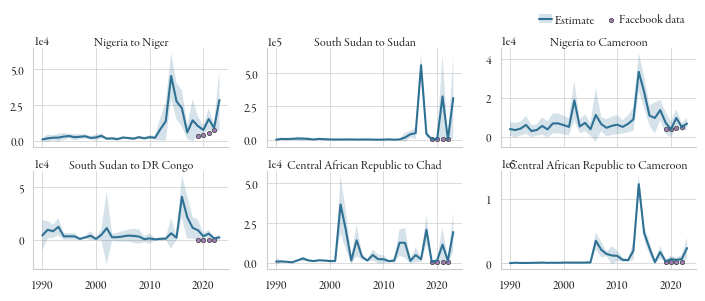

In [14]:
# Plot an example pane
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/3), sharex=True, gridspec_kw={'hspace': 0.25})

handles = {}
for idx, (o, d) in enumerate([("NGA", "NER"), ("SSD", "SDN"), ("NGA", "CMR"), ("SSD", "COD"), ("CAF", "TCD"), ("CAF", "CMR")]):
    _h1 = putils.errorband(predictions['F_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    handles['Estimate'] = _h1
    handles.update(**putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d))
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', x=0.5, ha='center', y=0.95)
    axs.flatten()[idx].ticklabel_format(style='sci', axis='y', scilimits=(2, 4))

fig.legend(handles=list(handles.values()), labels=list(handles.keys()), bbox_to_anchor=(1, 1.05), loc='lower right', columnspacing=0.8, ncols=6, handletextpad=0.2)
#fig.savefig(f"{img_dir}/Africa_2014_flows.pdf")

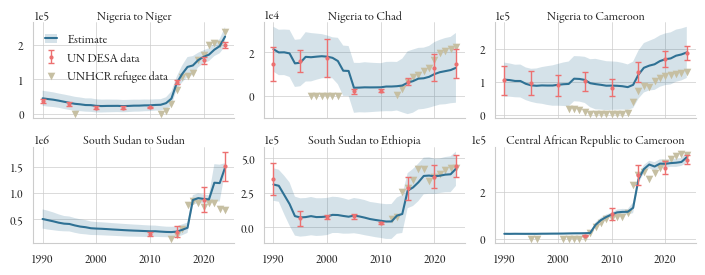

In [15]:
# Comparison of stocks
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/3), sharex=True, gridspec_kw={'hspace': 0.3, 'wspace': 0.15})

for idx, (o, d) in enumerate([("NGA", "NER"), ("NGA", "TCD"), ("NGA", "CMR"), ("SSD", "SDN"), ("SSD", "ETH"), ("CAF", "CMR")]):
    _h1 = putils.errorband(predictions['S_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    _h2 = putils.errorbar(stock_data.sel({"Origin ISO": o, "Destination ISO": d}, drop=True), axs.flatten()[idx], y='2025 Revision', yerr='Error', lw=0, elinewidth=1, capsize=2, markersize=2, marker='o', zorder=2)
    axs.flatten()[idx].set(xlabel=None, ylabel=None)

    # Plot the stock of refugees
    _h3 = refugees.sel({"Origin ISO": o, "Destination ISO": d}, drop=True).where(lambda x: x>0).plot.scatter(
        ax=axs.flatten()[idx], label='UNHCR refugee data', s=30, lw=0, c=colors['c_lightbrown'], marker='v')
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', y=0.95)
    axs.flatten()[idx].set(ylabel=None, xlabel=None)
    axs.flatten()[idx].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

axs[-1, -1].yaxis.get_offset_text().set_x(-0.12)

axs[0, 0].legend(handles=[_h1, _h2, _h3], labels=['Estimate', 'UN DESA data', 'UNHCR refugee data'])
#fig.savefig(f"{img_dir}/Africa_2014_stocks.pdf", pad_inches=0)

## East Asia, 2023

100%|██████████| 57/57 [00:00<00:00, 242.78it/s]


Text(15028131.257091988, 2258423.6490963884, 'Vietnam to Japan: 147365')

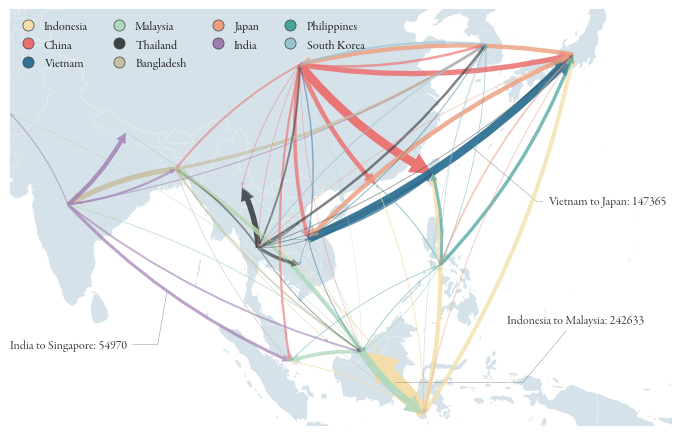

In [21]:
region = np.concatenate([countries_by_region['Eastern Asia'], countries_by_region['South-eastern Asia'], countries_by_region['Southern Asia']])

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Mercator()))
ax.axis('off')
patches = putils.add_country_patches(
    world.to_crs(ax.projection), ax,
    country_list=np.concatenate([region, countries_by_region['Central Asia'], countries_by_region['Oceania'], [-99]]), facecolor=colors['c_darkblue'], alpha=0.2)
putils.add_borders(ax, edgecolor='#ECF3F6', linewidth=0.5)
ax.set_extent([70, 150, -5, 33])

# Flow items
flow_items = putils.get_flow_items(predictions['F_pred']['mean'].sel({"Year": 2023, "Origin ISO": region, "Destination ISO": region}))[:100]

# Colour dictionary
color_dict_asia=dict(
                CHN=colors['c_red'],
                KOR=colors['c_lightblue'],
                JPN=colors['c_orange'],
                IND=colors['c_purple'],
                THA=colors['c_darkgrey'],
                VNM=colors['c_darkblue'],
                PHL='#47A29C',
                MYS=colors['c_lightgreen'],
                IDN=colors['c_yellow'],
                BGD=colors['c_lightbrown']
                )

handles = {}
for idx, item in enumerate(flow_items):

    if item['Origin ISO'] in color_dict_asia.keys():
        putils.plot_flows(fig,
                   flow_items=[item],
                   scale=2e-4,
                   shrinkA=0, shrinkB=0,
                   color = color_dict_asia[item['Origin ISO']],
                   alpha=max(0.5, np.exp(-idx/70)),
                   zorder=2+idx,
                   connectionstyle=f'arc3,rad=0.1',
                   arrowstyle='simple' if item['Value'] > 20000 else 'simple,head_length=1,head_width=1',
                   lw=0.
        )
        handles[putils.iso_to_name(item['Origin ISO'])] = Line2D([0], [0], marker='o', lw=0, markeredgewidth=0.5, c=colors['c_darkgrey'], markerfacecolor=color_dict_asia[item['Origin ISO']], markersize=8)

# Set size with fixed width and computed height
bbox = fig.get_tightbbox(fig.canvas.get_renderer())
aspect = bbox.height / bbox.width
fig.set_size_inches(page_width, page_width * aspect)

# Add legend to plot
fig.legend(handles=list(handles.values()), labels=list(handles.keys()),loc='upper left', bbox_to_anchor=(0., 1), ncols=4, framealpha=0.)

# Annotate some flows
v = predictions['F_pred']['mean'].sel({'Origin ISO': 'IDN', 'Destination ISO': 'MYS', 'Year': 2023})
ax.annotate(f'Indonesia to Malaysia: {v:>.0f}',
            xy=putils.coordinate_to_proj(ax, (0.5*coordinates['IDN'][0]+0.5*coordinates['MYS'][0]), (0.5*coordinates['MYS'][1]+0.5*coordinates['IDN'][1])),
            xytext=putils.coordinate_to_proj(ax, 6, 130),
            xycoords=ax.transData,
            color=colors['c_darkgrey'],
            arrowprops=dict(arrowstyle="-", connectionstyle="angle,angleA=50,angleB=00", lw=0.2, color=colors['c_darkgrey']))
v = predictions['F_pred']['mean'].sel({'Origin ISO': 'IND', 'Destination ISO': 'SGP', 'Year': 2023})
ax.annotate(f'India to Singapore: {v:>.0f}',
            xy=putils.coordinate_to_proj(ax, 10, 89),
            xytext=putils.coordinate_to_proj(ax, 3, 70),
            xycoords=ax.transData,
            color=colors['c_darkgrey'],
            arrowprops=dict(arrowstyle="-", connectionstyle="angle,angleA=0,angleB=80", lw=0.2, color=colors['c_darkgrey']))

v = predictions['F_pred']['mean'].sel({'Origin ISO': 'VNM', 'Destination ISO': 'JPN', 'Year': 2023})
ax.annotate(f'Vietnam to Japan: {v:>.0f}',
            xy=putils.coordinate_to_proj(ax, 27, 125),
            xytext=putils.coordinate_to_proj(ax, 20, 135),
            xycoords=ax.transData,
            color=colors['c_darkgrey'],
            arrowprops=dict(arrowstyle="-", connectionstyle="angle,angleA=0,angleB=-40", lw=0.2, color=colors['c_darkgrey']))

#fig.savefig(f"{img_dir}/E_Asia_flow_map.pdf", pad_inches=0)

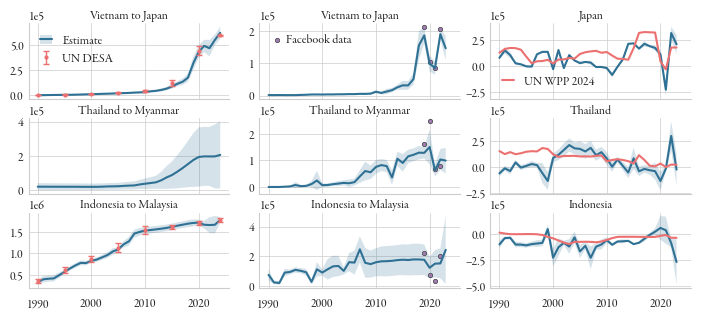

In [22]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(page_width, page_width*0.4), sharex=True, gridspec_kw={'wspace': 0.15, 'hspace': 0.25})

# Stocks
for row, (o, d) in enumerate([("VNM", "JPN"), ("THA", "MMR"), ("IDN", "MYS")]):
    _h1 = putils.errorband(predictions['S_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs[row, 0])
    _h2 = putils.errorbar(stock_data.sel({"Origin ISO": o, "Destination ISO": d}, drop=True), axs[row, 0], y='2025 Revision', yerr='Error', lw=0, elinewidth=1, capsize=2, markersize=2, marker='o', zorder=2)
    axs[row, 0].set(xlabel=None, ylabel=None)

    axs[row, 0].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', y=.95)
    axs[row, 0].set(ylabel=None, xlabel=None)
axs[0, 0].legend(handles=[_h1, _h2], labels=['Estimate', 'UN DESA'])

# Flows
handles = {}
for row, (o, d) in enumerate([("VNM", "JPN"), ("THA", "MMR"), ("IDN", "MYS")]):
    _h1 = putils.errorband(predictions['F_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs[row, 1])
    handles['Estimate'] = _h1
    handles.update(**putils.plot_flow_data(axs[row, 1], flow_dsets, o=o, d=d))
    axs[row, 1].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', x=0.5, ha='center', y=.95)

axs[0, 1].legend(handles=list(handles.values())[1:], labels=list(handles.keys())[1:], bbox_to_anchor=(0, 1), loc='upper left', columnspacing=0.8, ncols=1, handletextpad=0.2)

# Comparison of net migration
for row, c in enumerate(['JPN', 'THA', 'IDN']):
    _h1 = putils.errorband(predictions['mu_pred'].sel({"Country ISO": c}), axs[row, -1])
    _h2 = WPP_net_migration.sel({"Country ISO": c, "Year": range(1990, 2024)}).plot(ax=axs[row, -1], ls='solid')
    axs[row, -1].set_title(f'{putils.iso_to_name(c)}', y=0.95)
    axs[row, -1].set(xlabel=None, ylabel=None)

axs[0, -1].legend(handles=[_h2[0]], labels=['UN WPP 2024'], bbox_to_anchor=(0, 0), loc='lower left')

for ax in axs.flatten():
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.tick_params(axis='y', pad=0)
#fig.savefig(f"{img_dir}/E_Asia_overview.pdf", pad_inches=0)

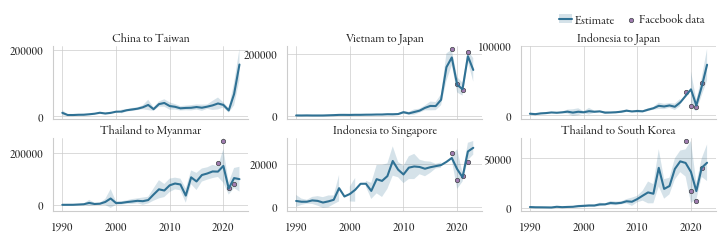

In [23]:
# Plot an example pane
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/4), sharex=True, gridspec_kw={'hspace': 0.25})

handles = {}
for idx, (o, d) in enumerate([("CHN", "TWN"), ("VNM", "JPN"), ("IDN", "JPN"), ("THA", "MMR"), ("IDN", "SGP"), ("THA", "KOR")]):
    _h1 = putils.errorband(predictions['F_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    handles['Estimate'] = _h1
    handles.update(**putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d))
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', x=0.5, ha='center', y=0.95)

fig.legend(handles=list(handles.values()), labels=list(handles.keys()), bbox_to_anchor=(1, 1.05), loc='lower right', columnspacing=0.8, ncols=6, handletextpad=0.2)

#fig.savefig("Images/E_Asia_flows.pdf")

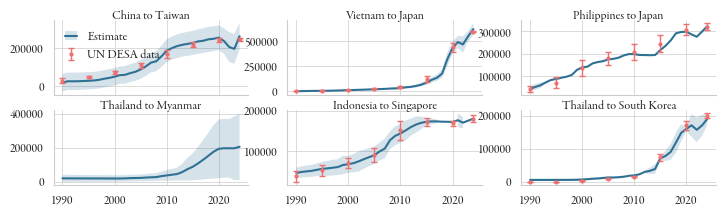

In [24]:
# Comparison of stocks
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/4), sharex=True)

for idx, (o, d) in enumerate([("CHN", "TWN"), ("VNM", "JPN"), ("PHL", "JPN"), ("THA", "MMR"), ("IDN", "SGP"), ("THA", "KOR")]):
    _h1 = putils.errorband(predictions['S_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    _h2 = putils.errorbar(stock_data.sel({"Origin ISO": o, "Destination ISO": d}, drop=True), axs.flatten()[idx], y='2025 Revision', yerr='Error', lw=0, elinewidth=1, capsize=2, markersize=2, marker='o', zorder=2)
    axs.flatten()[idx].set(xlabel=None, ylabel=None)

    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', y=0.9)
    axs.flatten()[idx].set(ylabel=None, xlabel=None)

axs[0, 0].legend(handles=[_h1, _h2], labels=['Estimate', 'UN DESA data'])
#fig.savefig("Images/E_Asia_stocks.pdf")

## Other plots

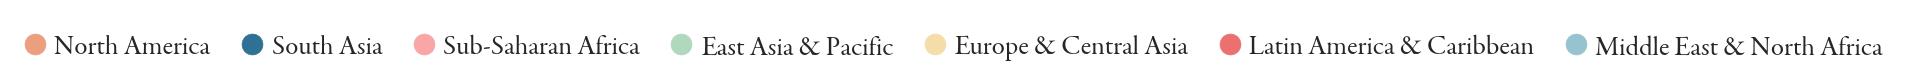

In [48]:
# Legend for chord diagramme
fig, ax= plt.subplots(figsize=(page_width, page_width/30))
ax.axis('off')
handles, labels = [], []
for color, name in [
    ('c_orange', 'North America'), ('c_darkblue', 'South Asia'), ('c_pink', 'Sub-Saharan Africa'), ('c_lightgreen', 'East Asia & Pacific'), ('c_yellow', 'Europe & Central Asia'), ('c_red', 'Latin America & Caribbean'), ('c_lightblue', 'Middle East & North Africa')]:
    handles.append(
        Line2D([0], [0], marker='o', lw=0, markeredgewidth=0.5, c=colors[color], markerfacecolor=colors[color], markersize=15)
    )
    labels.append(name)
legend = ax.legend(handles=handles, labels=labels, ncols=len(handles), fontsize=20, columnspacing=1, handletextpad=0.2)
# # bbox = fig.get_tightbbox(fig.canvas.get_renderer())
# # aspect = bbox.height / bbox.width
# # fig.set_size_inches(page_width, page_width * aspect)
# fig.savefig("Images/chord_legend.pdf", bbox_inches='tight', pad_inches=0)

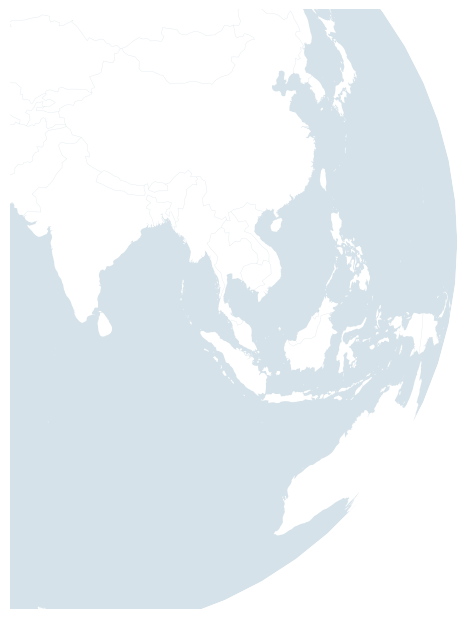

In [25]:
# Background for presentations
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection=ccrs.Orthographic(central_longitude=75, central_latitude=20))
ax.axis('off')
#ax.set(facecolor='#536E66', alpha=1)

# Set the colour scheme
cm = ColorManager(cmap={'from_values': {1995: colors['c_red'], 2005: colors['c_darkblue'], 2015: colors['c_darkgreen'], 2025: colors['c_orange']}})

putils.add_borders(ax, edgecolor=colors['c_darkblue'], alpha=0.2)
putils.add_ocean(ax, alpha=0.2, color=colors['c_darkblue'])
ax.set_extent([65, 163, -50, 40], crs=ccrs.PlateCarree())

# for flow in largest_flows[:10000]:
#
#     plot_arrow(fig,
#                ax_idx=0,
#                coord1=get_random_coord_in_country(fig, flow['Origin ISO'], coordinates=coordinates, jiggle=0.1),
#                coord2=get_random_coord_in_country(fig, flow['Destination ISO'], coordinates=coordinates, jiggle=0.02),
#                mutation_scale=1e-5*flow['Value'],
#                connectionstyle='arc3,rad=-0.2' if coordinates[flow['Origin ISO']][0] < coordinates[flow['Destination ISO']][1] else 'arc3, rad=0.2',
#                arrowstyle='wedge,tail_width=0.05,shrink_factor=2',
#                alpha=0.6,
#                color=cm.map_to_color(flow['Year']),
#                lw=0)
